<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import cifar10
import tensorflow as tf
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Reshape, BatchNormalization, Flatten, Conv2D, UpSampling2D, LeakyReLU, Dropout, ZeroPadding2D, ReLU, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os.mkdir('images')

In [3]:
batch_size = 128 # Размер batch_size
(X_train_cifar, y_train_cifar), (_, _) = cifar10.load_data() # Загружаем в X_train_cifar изображения из cifar


170508288/170498071 [==============================] - 3s 0us/step


In [4]:
X_train_cifar = X_train_cifar[np.where(y_train_cifar == 0)[0]] # выберем только изображения с самолетами

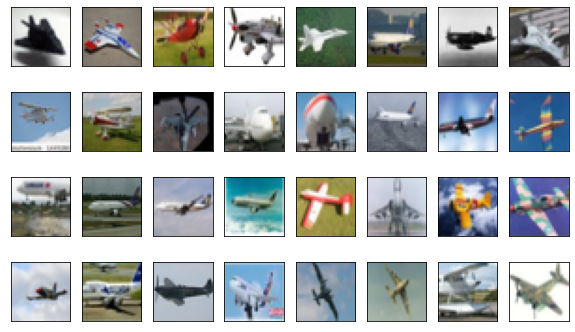

In [5]:
some_samples = X_train_cifar[:32]

fig = plt.figure(figsize=(10,6))
for i in range(some_samples.shape[0]):
  ax = fig.add_subplot(4, 8, i + 1)
  ax.imshow(some_samples[i,...])
  plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
X_train_cifar = X_train_cifar / 127.5 - 1. # Трансофрмируем значение в диапазон от -1 до 1

In [7]:
img_rows = 32 # Высота изображения cifar в пикселях
img_cols = 32 # Ширина изображения cifar в пикселях
channels = 3 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора cifar
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size
optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [8]:
def sample_images_cifar(epoch, gen): # Функция печати изображений
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise)  # Предиктим картинку с помощью входной переменной gen

  gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,:]) # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

In [9]:
def train_cifar(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения   
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size
  
  z = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train_cifar.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train_cifar.shape[0] длинной batch_size
    imgs = X_train_cifar[idx] # В переменную imgs записываем значение из X_train_cifar с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim_cifar) из нормально распределенных значений

    gen_imgs = generator.predict(noise) # Предиктим картинку с помощью входной переменной generator
   
    d_loss_real = discriminator.train_on_batch(imgs, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам 

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim_cifar) из нормально распределенных значений

    g_loss = combined.train_on_batch(noise, valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
        sample_images_cifar(epoch, generator)

  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания   
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

# Эксперимент №1

сделаем всё как в методичке

In [10]:
currGen = Sequential() # Инициализируем модель currGen

currGen.add(Dense(256, input_dim=latent_dim))  # Добавляем Dense-слой на 256 нейронов (размерность входных данных = latent_dim)
currGen.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currGen.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
currGen.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
currGen.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currGen.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
currGen.add(Dense(1024)) # Добавляем Dense-слой на 1024 нейронов
currGen.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currGen.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
currGen.add(Dense(np.prod(img_shape), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
currGen.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows_cifar, img_cols_cifar, channels_cifar))

noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
img = currGen(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

generator_cifar = Model(noise, img) # создаем модель generator_cifar (входные данные: noise, выходные данные: img)

In [11]:
currDisc = Sequential() # Инициализируем модель currDisc

currDisc.add(Flatten(input_shape=img_shape)) # Создаем слой Flatten (размерность входных данных = (img_rows_cifar, img_cols_cifar, channels_cifar), размерность выходных данных = img_rows_cifar * img_cols *_cifar * channels )
currDisc.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currDisc.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currDisc.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows_cifar, img_cols_cifar, channels_cifar) в img)
validity = currDisc(img) # Записываем в переменную validity значение, возвращаемое currDisc'ом с входным параметром img

discriminator_cifar = Model(img, validity) # Создаем модель discriminator_cifar (входные данные: img, выходные данные: validity)

 # Компилируем модель дискриманотра
discriminator_cifar.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

discriminator_cifar.trainable = False # Замораживаем обучение дискриматора 

0 [D loss: 0.752815, acc.: 25.78%] [G loss: 0.541100]


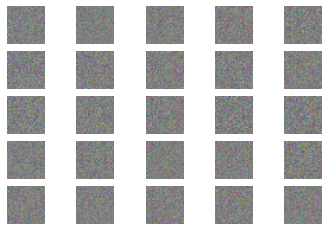

1 [D loss: 0.475160, acc.: 84.38%] [G loss: 0.439956]
2 [D loss: 0.417328, acc.: 76.56%] [G loss: 0.339974]
3 [D loss: 0.449398, acc.: 62.11%] [G loss: 0.291761]
4 [D loss: 0.463812, acc.: 59.38%] [G loss: 0.292194]
5 [D loss: 0.492880, acc.: 52.73%] [G loss: 0.281018]
6 [D loss: 0.432378, acc.: 67.19%] [G loss: 0.316391]
7 [D loss: 0.394813, acc.: 78.52%] [G loss: 0.345033]
8 [D loss: 0.407120, acc.: 80.47%] [G loss: 0.369012]
9 [D loss: 0.383312, acc.: 83.59%] [G loss: 0.459674]
10 [D loss: 0.410876, acc.: 78.52%] [G loss: 0.588102]
11 [D loss: 0.438827, acc.: 74.22%] [G loss: 0.738271]
12 [D loss: 0.434135, acc.: 74.22%] [G loss: 0.867430]
13 [D loss: 0.397304, acc.: 80.08%] [G loss: 1.077253]
14 [D loss: 0.449478, acc.: 75.78%] [G loss: 1.132061]
15 [D loss: 0.405080, acc.: 79.69%] [G loss: 1.327885]
16 [D loss: 0.375406, acc.: 82.81%] [G loss: 1.463302]
17 [D loss: 0.302121, acc.: 89.45%] [G loss: 1.590428]
18 [D loss: 0.421403, acc.: 83.59%] [G loss: 1.567571]
19 [D loss: 0.37944

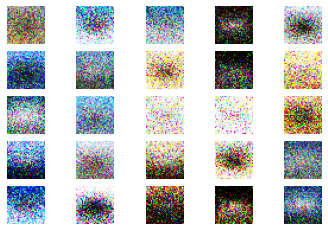

201 [D loss: 0.588379, acc.: 71.88%] [G loss: 1.564430]
202 [D loss: 0.651376, acc.: 63.67%] [G loss: 1.649506]
203 [D loss: 0.594379, acc.: 73.05%] [G loss: 1.650928]
204 [D loss: 0.630813, acc.: 65.23%] [G loss: 1.617158]
205 [D loss: 0.658977, acc.: 59.77%] [G loss: 1.581941]
206 [D loss: 0.715548, acc.: 56.25%] [G loss: 1.707740]
207 [D loss: 0.634824, acc.: 61.33%] [G loss: 1.584559]
208 [D loss: 0.700579, acc.: 55.86%] [G loss: 1.546004]
209 [D loss: 0.666030, acc.: 63.67%] [G loss: 1.568619]
210 [D loss: 0.704125, acc.: 53.52%] [G loss: 1.608364]
211 [D loss: 0.680962, acc.: 58.98%] [G loss: 1.546502]
212 [D loss: 0.647349, acc.: 64.45%] [G loss: 1.716192]
213 [D loss: 0.661610, acc.: 64.84%] [G loss: 1.675894]
214 [D loss: 0.683048, acc.: 58.59%] [G loss: 1.510446]
215 [D loss: 0.637947, acc.: 61.72%] [G loss: 1.587823]
216 [D loss: 0.665584, acc.: 61.72%] [G loss: 1.591520]
217 [D loss: 0.677974, acc.: 57.42%] [G loss: 1.559031]
218 [D loss: 0.658807, acc.: 59.77%] [G loss: 1.

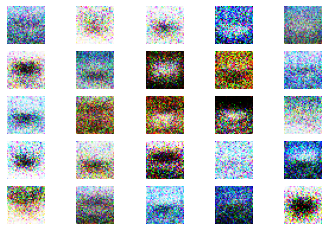

401 [D loss: 0.706963, acc.: 55.08%] [G loss: 1.381956]
402 [D loss: 0.623063, acc.: 67.19%] [G loss: 1.443690]
403 [D loss: 0.638389, acc.: 67.58%] [G loss: 1.425257]
404 [D loss: 0.657311, acc.: 57.03%] [G loss: 1.338518]
405 [D loss: 0.603547, acc.: 66.41%] [G loss: 1.591759]
406 [D loss: 0.687138, acc.: 57.03%] [G loss: 1.312076]
407 [D loss: 0.655715, acc.: 60.55%] [G loss: 1.387728]
408 [D loss: 0.657198, acc.: 60.55%] [G loss: 1.320693]
409 [D loss: 0.653402, acc.: 64.45%] [G loss: 1.433316]
410 [D loss: 0.616029, acc.: 62.89%] [G loss: 1.380331]
411 [D loss: 0.593520, acc.: 67.58%] [G loss: 1.398559]
412 [D loss: 0.647999, acc.: 62.50%] [G loss: 1.417502]
413 [D loss: 0.623019, acc.: 64.45%] [G loss: 1.394630]
414 [D loss: 0.630363, acc.: 67.19%] [G loss: 1.404250]
415 [D loss: 0.645758, acc.: 60.16%] [G loss: 1.445179]
416 [D loss: 0.642149, acc.: 63.67%] [G loss: 1.392253]
417 [D loss: 0.633795, acc.: 63.28%] [G loss: 1.393962]
418 [D loss: 0.649891, acc.: 56.64%] [G loss: 1.

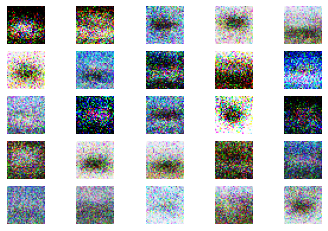

601 [D loss: 0.670237, acc.: 57.42%] [G loss: 1.211173]
602 [D loss: 0.639970, acc.: 69.53%] [G loss: 1.227153]
603 [D loss: 0.678596, acc.: 57.42%] [G loss: 1.295529]
604 [D loss: 0.670754, acc.: 57.81%] [G loss: 1.277979]
605 [D loss: 0.677997, acc.: 52.73%] [G loss: 1.225653]
606 [D loss: 0.641299, acc.: 64.06%] [G loss: 1.299876]
607 [D loss: 0.686008, acc.: 52.34%] [G loss: 1.158530]
608 [D loss: 0.610274, acc.: 69.92%] [G loss: 1.131853]
609 [D loss: 0.651416, acc.: 61.33%] [G loss: 1.238558]
610 [D loss: 0.643419, acc.: 65.23%] [G loss: 1.232713]
611 [D loss: 0.666892, acc.: 55.86%] [G loss: 1.246680]
612 [D loss: 0.702236, acc.: 54.69%] [G loss: 1.281765]
613 [D loss: 0.650253, acc.: 59.77%] [G loss: 1.221559]
614 [D loss: 0.659221, acc.: 68.75%] [G loss: 1.330968]
615 [D loss: 0.694084, acc.: 51.56%] [G loss: 1.256671]
616 [D loss: 0.664049, acc.: 65.62%] [G loss: 1.258145]
617 [D loss: 0.731766, acc.: 51.95%] [G loss: 1.318564]
618 [D loss: 0.670279, acc.: 59.77%] [G loss: 1.

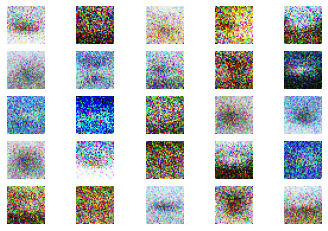

801 [D loss: 0.647243, acc.: 59.38%] [G loss: 1.130640]
802 [D loss: 0.666862, acc.: 55.86%] [G loss: 1.178924]
803 [D loss: 0.645539, acc.: 64.45%] [G loss: 1.177579]
804 [D loss: 0.668364, acc.: 56.64%] [G loss: 1.131989]
805 [D loss: 0.624750, acc.: 66.41%] [G loss: 1.181918]
806 [D loss: 0.665441, acc.: 62.89%] [G loss: 1.178557]
807 [D loss: 0.633231, acc.: 64.84%] [G loss: 1.312940]
808 [D loss: 0.747372, acc.: 39.84%] [G loss: 1.182624]
809 [D loss: 0.655842, acc.: 67.19%] [G loss: 1.278435]
810 [D loss: 0.720152, acc.: 51.17%] [G loss: 1.094795]
811 [D loss: 0.626741, acc.: 62.89%] [G loss: 1.059522]
812 [D loss: 0.640013, acc.: 62.89%] [G loss: 1.195346]
813 [D loss: 0.651131, acc.: 62.11%] [G loss: 1.180408]
814 [D loss: 0.695091, acc.: 51.56%] [G loss: 1.269578]
815 [D loss: 0.672673, acc.: 56.64%] [G loss: 1.303894]
816 [D loss: 0.782537, acc.: 42.97%] [G loss: 1.129936]
817 [D loss: 0.687913, acc.: 60.16%] [G loss: 1.259757]
818 [D loss: 0.706470, acc.: 55.47%] [G loss: 1.

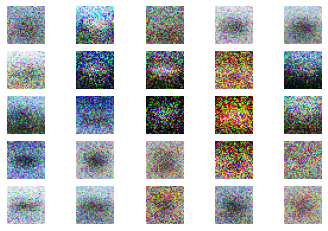

1001 [D loss: 0.714858, acc.: 47.66%] [G loss: 0.974371]
1002 [D loss: 0.662796, acc.: 60.94%] [G loss: 0.958975]
1003 [D loss: 0.685986, acc.: 57.03%] [G loss: 0.958791]
1004 [D loss: 0.654781, acc.: 60.94%] [G loss: 1.048727]
1005 [D loss: 0.680313, acc.: 50.39%] [G loss: 1.052682]
1006 [D loss: 0.661181, acc.: 59.38%] [G loss: 1.030737]
1007 [D loss: 0.680297, acc.: 57.42%] [G loss: 1.102619]
1008 [D loss: 0.727943, acc.: 48.44%] [G loss: 1.079316]
1009 [D loss: 0.690265, acc.: 54.69%] [G loss: 1.036606]
1010 [D loss: 0.651401, acc.: 58.59%] [G loss: 1.019957]
1011 [D loss: 0.657001, acc.: 62.11%] [G loss: 1.055780]
1012 [D loss: 0.677781, acc.: 55.86%] [G loss: 1.034517]
1013 [D loss: 0.657394, acc.: 64.06%] [G loss: 0.997189]
1014 [D loss: 0.697847, acc.: 55.08%] [G loss: 1.073574]
1015 [D loss: 0.653808, acc.: 62.89%] [G loss: 1.021571]
1016 [D loss: 0.621839, acc.: 64.06%] [G loss: 1.105689]
1017 [D loss: 0.675303, acc.: 56.25%] [G loss: 1.000817]
1018 [D loss: 0.668808, acc.: 5

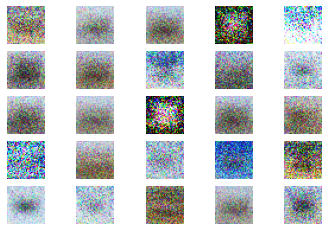

1201 [D loss: 0.641920, acc.: 61.33%] [G loss: 1.412053]
1202 [D loss: 0.747997, acc.: 37.11%] [G loss: 1.473687]
1203 [D loss: 0.788703, acc.: 48.44%] [G loss: 1.197686]
1204 [D loss: 0.753697, acc.: 44.14%] [G loss: 1.023464]
1205 [D loss: 0.673068, acc.: 55.08%] [G loss: 1.062828]
1206 [D loss: 0.637974, acc.: 61.72%] [G loss: 1.154180]
1207 [D loss: 0.596147, acc.: 70.70%] [G loss: 1.213613]
1208 [D loss: 0.594266, acc.: 75.00%] [G loss: 1.316460]
1209 [D loss: 0.548715, acc.: 77.34%] [G loss: 1.437420]
1210 [D loss: 0.563705, acc.: 68.75%] [G loss: 1.304966]
1211 [D loss: 0.581569, acc.: 74.61%] [G loss: 1.290450]
1212 [D loss: 0.630392, acc.: 64.45%] [G loss: 1.437152]
1213 [D loss: 0.615438, acc.: 66.80%] [G loss: 1.580679]
1214 [D loss: 0.626017, acc.: 61.33%] [G loss: 1.305335]
1215 [D loss: 0.583998, acc.: 69.53%] [G loss: 1.458898]
1216 [D loss: 0.574052, acc.: 74.22%] [G loss: 1.471017]
1217 [D loss: 0.559224, acc.: 70.70%] [G loss: 1.682075]
1218 [D loss: 0.614226, acc.: 6

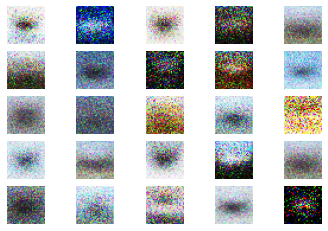

1401 [D loss: 0.486437, acc.: 84.77%] [G loss: 1.736782]
1402 [D loss: 0.524805, acc.: 83.59%] [G loss: 1.628143]
1403 [D loss: 0.537168, acc.: 72.66%] [G loss: 2.146046]
1404 [D loss: 0.648171, acc.: 54.69%] [G loss: 3.069878]
1405 [D loss: 0.677102, acc.: 55.86%] [G loss: 2.679622]
1406 [D loss: 0.702060, acc.: 56.64%] [G loss: 1.577615]
1407 [D loss: 0.596366, acc.: 70.31%] [G loss: 1.591164]
1408 [D loss: 0.524004, acc.: 78.91%] [G loss: 1.624879]
1409 [D loss: 0.602831, acc.: 72.27%] [G loss: 1.655097]
1410 [D loss: 0.576335, acc.: 71.09%] [G loss: 2.010155]
1411 [D loss: 0.614613, acc.: 69.14%] [G loss: 1.472205]
1412 [D loss: 0.519718, acc.: 75.78%] [G loss: 1.921026]
1413 [D loss: 0.500292, acc.: 79.30%] [G loss: 1.629938]
1414 [D loss: 0.520302, acc.: 76.17%] [G loss: 1.932134]
1415 [D loss: 0.429716, acc.: 87.11%] [G loss: 2.384296]
1416 [D loss: 0.584543, acc.: 67.97%] [G loss: 1.697782]
1417 [D loss: 0.584133, acc.: 68.75%] [G loss: 1.639626]
1418 [D loss: 0.597012, acc.: 6

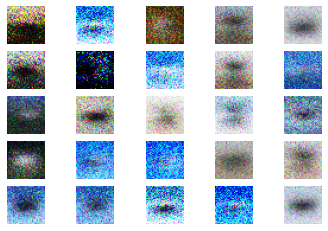

1601 [D loss: 0.505465, acc.: 75.78%] [G loss: 1.982784]
1602 [D loss: 0.448554, acc.: 83.20%] [G loss: 1.955142]
1603 [D loss: 0.526242, acc.: 79.69%] [G loss: 1.503047]
1604 [D loss: 0.498761, acc.: 76.17%] [G loss: 1.659859]
1605 [D loss: 0.560289, acc.: 73.83%] [G loss: 1.541462]
1606 [D loss: 0.546293, acc.: 73.44%] [G loss: 1.506387]
1607 [D loss: 0.556332, acc.: 71.48%] [G loss: 2.006204]
1608 [D loss: 0.524791, acc.: 73.83%] [G loss: 3.880469]
1609 [D loss: 0.744992, acc.: 55.47%] [G loss: 3.363070]
1610 [D loss: 0.694913, acc.: 59.38%] [G loss: 1.544776]
1611 [D loss: 0.508397, acc.: 77.73%] [G loss: 1.805576]
1612 [D loss: 0.573415, acc.: 70.31%] [G loss: 2.315284]
1613 [D loss: 0.633456, acc.: 63.28%] [G loss: 1.381221]
1614 [D loss: 0.521489, acc.: 75.39%] [G loss: 1.716048]
1615 [D loss: 0.499171, acc.: 77.73%] [G loss: 1.689476]
1616 [D loss: 0.516706, acc.: 78.12%] [G loss: 1.574245]
1617 [D loss: 0.502355, acc.: 78.91%] [G loss: 1.870679]
1618 [D loss: 0.502755, acc.: 7

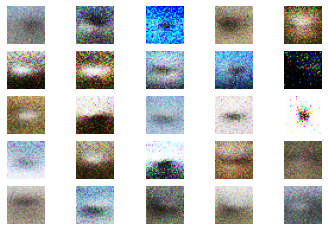

1801 [D loss: 0.582421, acc.: 69.14%] [G loss: 1.613673]
1802 [D loss: 0.580939, acc.: 68.75%] [G loss: 1.654342]
1803 [D loss: 0.565483, acc.: 70.70%] [G loss: 1.415057]
1804 [D loss: 0.504689, acc.: 79.30%] [G loss: 1.563854]
1805 [D loss: 0.600972, acc.: 65.23%] [G loss: 1.150852]
1806 [D loss: 0.538106, acc.: 78.12%] [G loss: 1.631782]
1807 [D loss: 0.607049, acc.: 62.11%] [G loss: 1.178153]
1808 [D loss: 0.554486, acc.: 71.09%] [G loss: 1.317364]
1809 [D loss: 0.502306, acc.: 83.59%] [G loss: 1.480008]
1810 [D loss: 0.414449, acc.: 84.77%] [G loss: 2.353912]
1811 [D loss: 0.409500, acc.: 85.55%] [G loss: 2.144095]
1812 [D loss: 0.480716, acc.: 75.78%] [G loss: 1.373534]
1813 [D loss: 0.514130, acc.: 71.88%] [G loss: 1.798234]
1814 [D loss: 0.535503, acc.: 71.88%] [G loss: 2.050343]
1815 [D loss: 0.665724, acc.: 59.77%] [G loss: 1.975922]
1816 [D loss: 0.662899, acc.: 64.45%] [G loss: 1.914547]
1817 [D loss: 0.488968, acc.: 80.86%] [G loss: 1.469094]
1818 [D loss: 0.532885, acc.: 7

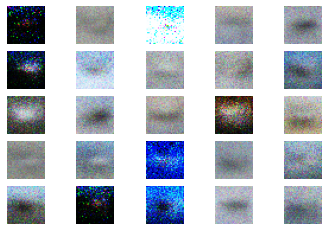

2001 [D loss: 0.534303, acc.: 69.53%] [G loss: 1.764003]
2002 [D loss: 0.514989, acc.: 73.44%] [G loss: 1.443211]
2003 [D loss: 0.515385, acc.: 70.70%] [G loss: 1.353030]
2004 [D loss: 0.464721, acc.: 79.69%] [G loss: 1.164778]
2005 [D loss: 0.528348, acc.: 70.31%] [G loss: 0.996347]
2006 [D loss: 0.556305, acc.: 68.36%] [G loss: 0.949221]
2007 [D loss: 0.549864, acc.: 72.27%] [G loss: 1.468460]
2008 [D loss: 0.606850, acc.: 63.28%] [G loss: 2.770522]
2009 [D loss: 0.840137, acc.: 56.25%] [G loss: 2.530571]
2010 [D loss: 1.030796, acc.: 35.94%] [G loss: 1.425681]
2011 [D loss: 0.694455, acc.: 59.38%] [G loss: 1.023137]
2012 [D loss: 0.647771, acc.: 53.52%] [G loss: 1.029827]
2013 [D loss: 0.586001, acc.: 60.94%] [G loss: 1.223192]
2014 [D loss: 0.642771, acc.: 58.59%] [G loss: 1.123243]
2015 [D loss: 0.582869, acc.: 66.80%] [G loss: 1.087345]
2016 [D loss: 0.614185, acc.: 57.42%] [G loss: 1.201454]
2017 [D loss: 0.507891, acc.: 78.12%] [G loss: 1.297359]
2018 [D loss: 0.546031, acc.: 7

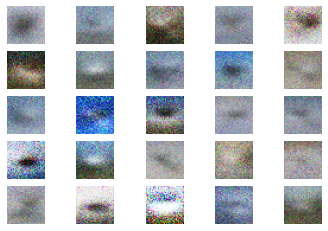

2201 [D loss: 0.487137, acc.: 71.48%] [G loss: 1.208324]
2202 [D loss: 0.611321, acc.: 60.55%] [G loss: 1.036917]
2203 [D loss: 0.515616, acc.: 67.58%] [G loss: 1.012700]
2204 [D loss: 0.524802, acc.: 70.70%] [G loss: 1.264024]
2205 [D loss: 0.549962, acc.: 67.19%] [G loss: 0.946305]
2206 [D loss: 0.564180, acc.: 66.02%] [G loss: 0.981078]
2207 [D loss: 0.546155, acc.: 65.62%] [G loss: 0.933049]
2208 [D loss: 0.536191, acc.: 71.88%] [G loss: 1.019694]
2209 [D loss: 0.510094, acc.: 72.27%] [G loss: 1.215746]
2210 [D loss: 0.504641, acc.: 75.00%] [G loss: 1.180920]
2211 [D loss: 0.512035, acc.: 72.27%] [G loss: 1.147601]
2212 [D loss: 0.513278, acc.: 73.05%] [G loss: 1.048808]
2213 [D loss: 0.468474, acc.: 77.34%] [G loss: 1.119896]
2214 [D loss: 0.516399, acc.: 67.58%] [G loss: 0.985398]
2215 [D loss: 0.538082, acc.: 69.14%] [G loss: 1.161496]
2216 [D loss: 0.515834, acc.: 74.61%] [G loss: 1.413573]
2217 [D loss: 0.549395, acc.: 70.31%] [G loss: 1.638004]
2218 [D loss: 0.592856, acc.: 6

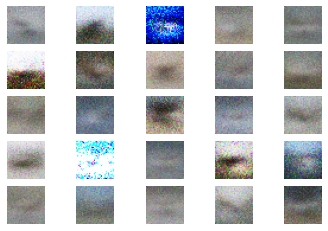

2401 [D loss: 0.463765, acc.: 78.91%] [G loss: 1.382984]
2402 [D loss: 0.526422, acc.: 66.41%] [G loss: 1.242106]
2403 [D loss: 0.475965, acc.: 78.52%] [G loss: 1.262571]
2404 [D loss: 0.443965, acc.: 78.91%] [G loss: 1.221470]
2405 [D loss: 0.504639, acc.: 76.95%] [G loss: 1.219075]
2406 [D loss: 0.480702, acc.: 77.73%] [G loss: 1.319609]
2407 [D loss: 0.456820, acc.: 80.86%] [G loss: 1.231796]
2408 [D loss: 0.477512, acc.: 77.73%] [G loss: 1.121315]
2409 [D loss: 0.501975, acc.: 75.00%] [G loss: 1.294380]
2410 [D loss: 0.439769, acc.: 78.52%] [G loss: 1.858359]
2411 [D loss: 0.463395, acc.: 75.39%] [G loss: 2.375903]
2412 [D loss: 0.433880, acc.: 76.17%] [G loss: 3.153684]
2413 [D loss: 0.689481, acc.: 51.56%] [G loss: 1.374685]
2414 [D loss: 0.501288, acc.: 72.27%] [G loss: 1.878155]
2415 [D loss: 0.542871, acc.: 63.67%] [G loss: 0.880825]
2416 [D loss: 0.433989, acc.: 79.69%] [G loss: 1.245647]
2417 [D loss: 0.491135, acc.: 74.61%] [G loss: 1.238911]
2418 [D loss: 0.434407, acc.: 8

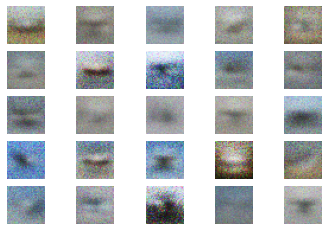

2601 [D loss: 0.437218, acc.: 82.81%] [G loss: 1.075056]
2602 [D loss: 0.479929, acc.: 77.73%] [G loss: 1.250327]
2603 [D loss: 0.453154, acc.: 82.03%] [G loss: 1.423841]
2604 [D loss: 0.451808, acc.: 81.64%] [G loss: 1.325127]
2605 [D loss: 0.480741, acc.: 76.95%] [G loss: 1.147607]
2606 [D loss: 0.516286, acc.: 73.44%] [G loss: 1.014203]
2607 [D loss: 0.511731, acc.: 76.17%] [G loss: 1.229995]
2608 [D loss: 0.527226, acc.: 71.09%] [G loss: 1.235458]
2609 [D loss: 0.609845, acc.: 65.62%] [G loss: 1.257950]
2610 [D loss: 0.543389, acc.: 69.53%] [G loss: 1.479083]
2611 [D loss: 0.417838, acc.: 82.81%] [G loss: 2.846445]
2612 [D loss: 0.516836, acc.: 76.17%] [G loss: 1.071171]
2613 [D loss: 0.404941, acc.: 82.03%] [G loss: 1.561665]
2614 [D loss: 0.412314, acc.: 82.03%] [G loss: 1.529794]
2615 [D loss: 0.348390, acc.: 85.94%] [G loss: 1.744290]
2616 [D loss: 0.468076, acc.: 78.12%] [G loss: 1.322412]
2617 [D loss: 0.447551, acc.: 78.12%] [G loss: 1.183467]
2618 [D loss: 0.496675, acc.: 7

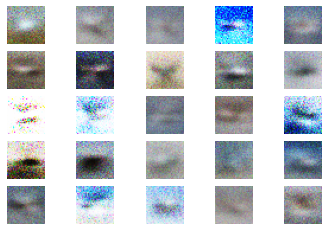

2801 [D loss: 0.508396, acc.: 73.44%] [G loss: 1.193161]
2802 [D loss: 0.487473, acc.: 76.17%] [G loss: 1.313748]
2803 [D loss: 0.454840, acc.: 83.20%] [G loss: 1.348662]
2804 [D loss: 0.451202, acc.: 78.91%] [G loss: 1.371180]
2805 [D loss: 0.465046, acc.: 78.52%] [G loss: 1.461418]
2806 [D loss: 0.456877, acc.: 79.30%] [G loss: 1.153404]
2807 [D loss: 0.492995, acc.: 74.22%] [G loss: 1.154129]
2808 [D loss: 0.444532, acc.: 83.20%] [G loss: 1.243641]
2809 [D loss: 0.508964, acc.: 76.17%] [G loss: 1.272721]
2810 [D loss: 0.411239, acc.: 87.89%] [G loss: 1.496373]
2811 [D loss: 0.364084, acc.: 87.89%] [G loss: 1.671856]
2812 [D loss: 0.450302, acc.: 79.69%] [G loss: 1.436898]
2813 [D loss: 0.397838, acc.: 87.50%] [G loss: 1.920619]
2814 [D loss: 0.379312, acc.: 86.72%] [G loss: 1.777664]
2815 [D loss: 0.394452, acc.: 83.20%] [G loss: 1.821451]
2816 [D loss: 0.491683, acc.: 80.47%] [G loss: 1.237620]
2817 [D loss: 0.495648, acc.: 74.61%] [G loss: 1.360511]
2818 [D loss: 0.459776, acc.: 8

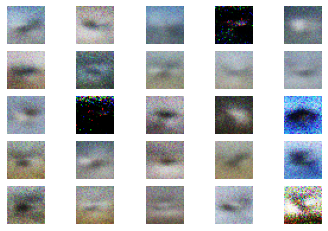

3001 [D loss: 0.409495, acc.: 83.59%] [G loss: 1.818694]
3002 [D loss: 0.377592, acc.: 82.03%] [G loss: 2.566101]
3003 [D loss: 0.423363, acc.: 78.12%] [G loss: 2.035752]
3004 [D loss: 0.444689, acc.: 78.52%] [G loss: 1.944821]
3005 [D loss: 0.398335, acc.: 83.98%] [G loss: 1.635816]
3006 [D loss: 0.491630, acc.: 74.61%] [G loss: 1.293446]
3007 [D loss: 0.432490, acc.: 83.59%] [G loss: 1.365036]
3008 [D loss: 0.460005, acc.: 81.64%] [G loss: 1.692496]
3009 [D loss: 0.423453, acc.: 78.91%] [G loss: 3.191568]
3010 [D loss: 0.542139, acc.: 76.95%] [G loss: 3.802531]
3011 [D loss: 0.936830, acc.: 50.78%] [G loss: 2.294035]
3012 [D loss: 0.615229, acc.: 69.92%] [G loss: 1.322452]
3013 [D loss: 0.567467, acc.: 68.75%] [G loss: 1.034682]
3014 [D loss: 0.444490, acc.: 80.47%] [G loss: 1.624361]
3015 [D loss: 0.513911, acc.: 73.05%] [G loss: 1.748444]
3016 [D loss: 0.427468, acc.: 80.86%] [G loss: 1.891035]
3017 [D loss: 0.417689, acc.: 81.64%] [G loss: 1.376983]
3018 [D loss: 0.478922, acc.: 7

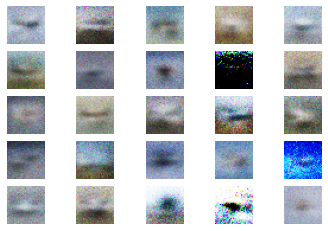

3201 [D loss: 0.432037, acc.: 78.91%] [G loss: 2.548906]
3202 [D loss: 0.411568, acc.: 83.20%] [G loss: 1.428834]
3203 [D loss: 0.387468, acc.: 83.20%] [G loss: 2.050940]
3204 [D loss: 0.405543, acc.: 85.16%] [G loss: 1.570813]
3205 [D loss: 0.417023, acc.: 83.98%] [G loss: 1.636249]
3206 [D loss: 0.385024, acc.: 83.20%] [G loss: 1.527556]
3207 [D loss: 0.391221, acc.: 83.98%] [G loss: 1.890758]
3208 [D loss: 0.400136, acc.: 85.94%] [G loss: 1.764854]
3209 [D loss: 0.404538, acc.: 86.33%] [G loss: 1.771835]
3210 [D loss: 0.402984, acc.: 83.59%] [G loss: 1.960470]
3211 [D loss: 0.339246, acc.: 84.77%] [G loss: 2.577680]
3212 [D loss: 0.330954, acc.: 90.23%] [G loss: 1.755806]
3213 [D loss: 0.420992, acc.: 83.20%] [G loss: 1.802887]
3214 [D loss: 0.366819, acc.: 88.28%] [G loss: 1.953900]
3215 [D loss: 0.451873, acc.: 76.56%] [G loss: 2.308995]
3216 [D loss: 0.426018, acc.: 80.08%] [G loss: 3.044939]
3217 [D loss: 0.662195, acc.: 67.58%] [G loss: 5.140165]
3218 [D loss: 1.111439, acc.: 4

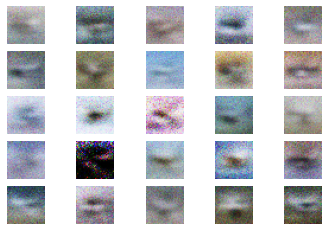

3401 [D loss: 0.599433, acc.: 67.58%] [G loss: 1.391432]
3402 [D loss: 0.477844, acc.: 73.44%] [G loss: 1.554425]
3403 [D loss: 0.384698, acc.: 85.94%] [G loss: 1.548469]
3404 [D loss: 0.407244, acc.: 83.98%] [G loss: 1.771619]
3405 [D loss: 0.430528, acc.: 80.47%] [G loss: 1.697661]
3406 [D loss: 0.387130, acc.: 85.16%] [G loss: 1.602637]
3407 [D loss: 0.458287, acc.: 78.91%] [G loss: 1.539963]
3408 [D loss: 0.451673, acc.: 82.42%] [G loss: 1.423572]
3409 [D loss: 0.410854, acc.: 80.86%] [G loss: 1.516995]
3410 [D loss: 0.448380, acc.: 80.86%] [G loss: 1.587273]
3411 [D loss: 0.547784, acc.: 71.48%] [G loss: 1.359020]
3412 [D loss: 0.419336, acc.: 85.16%] [G loss: 1.522583]
3413 [D loss: 0.479727, acc.: 77.34%] [G loss: 1.474729]
3414 [D loss: 0.433319, acc.: 81.25%] [G loss: 1.443855]
3415 [D loss: 0.430978, acc.: 82.03%] [G loss: 1.471915]
3416 [D loss: 0.404771, acc.: 87.11%] [G loss: 1.409564]
3417 [D loss: 0.410009, acc.: 82.03%] [G loss: 1.525333]
3418 [D loss: 0.457629, acc.: 8

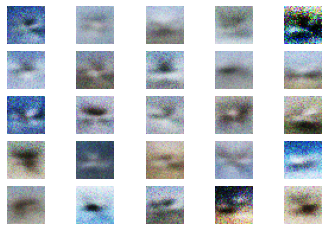

3601 [D loss: 0.341603, acc.: 86.72%] [G loss: 2.068323]
3602 [D loss: 0.352572, acc.: 84.77%] [G loss: 2.174372]
3603 [D loss: 0.417458, acc.: 82.81%] [G loss: 1.698762]
3604 [D loss: 0.409190, acc.: 85.16%] [G loss: 1.889833]
3605 [D loss: 0.427500, acc.: 81.25%] [G loss: 1.797835]
3606 [D loss: 0.414003, acc.: 81.64%] [G loss: 1.650656]
3607 [D loss: 0.378750, acc.: 85.55%] [G loss: 1.979447]
3608 [D loss: 0.432237, acc.: 81.25%] [G loss: 1.807035]
3609 [D loss: 0.400333, acc.: 84.77%] [G loss: 1.930936]
3610 [D loss: 0.446742, acc.: 80.08%] [G loss: 1.770349]
3611 [D loss: 0.409468, acc.: 85.16%] [G loss: 2.006645]
3612 [D loss: 0.448970, acc.: 79.30%] [G loss: 1.726438]
3613 [D loss: 0.385972, acc.: 84.77%] [G loss: 1.866184]
3614 [D loss: 0.400637, acc.: 82.42%] [G loss: 1.465512]
3615 [D loss: 0.412741, acc.: 86.33%] [G loss: 1.541170]
3616 [D loss: 0.418820, acc.: 81.25%] [G loss: 1.936539]
3617 [D loss: 0.360155, acc.: 87.89%] [G loss: 2.714972]
3618 [D loss: 0.468333, acc.: 7

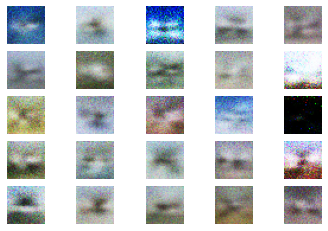

3801 [D loss: 0.429965, acc.: 75.39%] [G loss: 1.984352]
3802 [D loss: 0.335749, acc.: 86.33%] [G loss: 2.602796]
3803 [D loss: 0.374227, acc.: 83.20%] [G loss: 2.751345]
3804 [D loss: 0.322865, acc.: 83.20%] [G loss: 4.371875]
3805 [D loss: 0.348576, acc.: 88.28%] [G loss: 2.625443]
3806 [D loss: 0.440553, acc.: 80.86%] [G loss: 1.765098]
3807 [D loss: 0.376272, acc.: 82.42%] [G loss: 2.375931]
3808 [D loss: 0.367079, acc.: 83.20%] [G loss: 1.712497]
3809 [D loss: 0.369198, acc.: 84.38%] [G loss: 2.215069]
3810 [D loss: 0.437316, acc.: 79.69%] [G loss: 2.304417]
3811 [D loss: 0.409027, acc.: 81.25%] [G loss: 2.119618]
3812 [D loss: 0.383131, acc.: 83.59%] [G loss: 2.555102]
3813 [D loss: 0.413282, acc.: 84.38%] [G loss: 1.624941]
3814 [D loss: 0.412177, acc.: 82.03%] [G loss: 2.415571]
3815 [D loss: 0.299146, acc.: 89.06%] [G loss: 3.787317]
3816 [D loss: 0.433253, acc.: 80.86%] [G loss: 1.894863]
3817 [D loss: 0.291098, acc.: 91.02%] [G loss: 3.079015]
3818 [D loss: 0.405340, acc.: 8

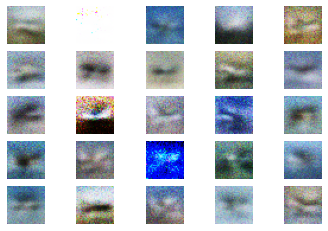

4001 [D loss: 0.447703, acc.: 80.86%] [G loss: 1.490700]
4002 [D loss: 0.451977, acc.: 81.25%] [G loss: 1.630770]
4003 [D loss: 0.405142, acc.: 85.55%] [G loss: 1.638314]
4004 [D loss: 0.448106, acc.: 80.08%] [G loss: 1.737566]
4005 [D loss: 0.410366, acc.: 83.20%] [G loss: 1.661793]
4006 [D loss: 0.433666, acc.: 80.86%] [G loss: 1.938392]
4007 [D loss: 0.349969, acc.: 86.72%] [G loss: 2.104776]
4008 [D loss: 0.408991, acc.: 83.20%] [G loss: 1.842040]
4009 [D loss: 0.388322, acc.: 82.42%] [G loss: 1.830269]
4010 [D loss: 0.428657, acc.: 79.30%] [G loss: 1.790944]
4011 [D loss: 0.441801, acc.: 79.69%] [G loss: 1.643147]
4012 [D loss: 0.361890, acc.: 87.89%] [G loss: 2.029270]
4013 [D loss: 0.332827, acc.: 85.94%] [G loss: 1.846627]
4014 [D loss: 0.433975, acc.: 80.47%] [G loss: 2.049450]
4015 [D loss: 0.325565, acc.: 87.89%] [G loss: 2.452601]
4016 [D loss: 0.353808, acc.: 84.77%] [G loss: 2.040429]
4017 [D loss: 0.384294, acc.: 84.38%] [G loss: 2.139896]
4018 [D loss: 0.360079, acc.: 8

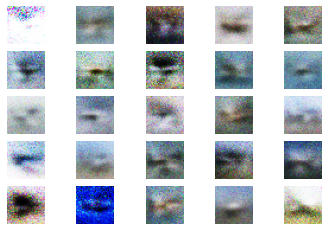

4201 [D loss: 0.342532, acc.: 83.98%] [G loss: 2.434843]
4202 [D loss: 0.344329, acc.: 87.11%] [G loss: 2.230728]
4203 [D loss: 0.344574, acc.: 85.55%] [G loss: 2.133175]
4204 [D loss: 0.388149, acc.: 83.59%] [G loss: 1.974395]
4205 [D loss: 0.463958, acc.: 77.34%] [G loss: 1.614879]
4206 [D loss: 0.329535, acc.: 89.45%] [G loss: 2.125131]
4207 [D loss: 0.403117, acc.: 83.20%] [G loss: 2.664790]
4208 [D loss: 0.377338, acc.: 83.59%] [G loss: 3.511150]
4209 [D loss: 0.335144, acc.: 85.94%] [G loss: 3.109323]
4210 [D loss: 0.370885, acc.: 83.59%] [G loss: 1.924268]
4211 [D loss: 0.324483, acc.: 86.72%] [G loss: 2.837601]
4212 [D loss: 0.309926, acc.: 88.28%] [G loss: 2.598410]
4213 [D loss: 0.395423, acc.: 85.16%] [G loss: 2.144226]
4214 [D loss: 0.349125, acc.: 88.67%] [G loss: 1.983101]
4215 [D loss: 0.398763, acc.: 81.25%] [G loss: 2.424841]
4216 [D loss: 0.344024, acc.: 86.72%] [G loss: 2.145048]
4217 [D loss: 0.387270, acc.: 84.38%] [G loss: 2.183898]
4218 [D loss: 0.316659, acc.: 8

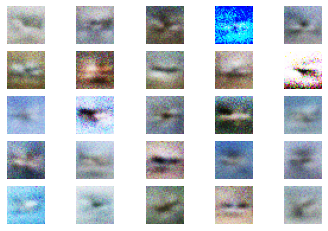

4401 [D loss: 0.316021, acc.: 91.02%] [G loss: 1.907578]
4402 [D loss: 0.365379, acc.: 84.77%] [G loss: 2.626602]
4403 [D loss: 0.429106, acc.: 80.47%] [G loss: 1.775686]
4404 [D loss: 0.356389, acc.: 87.89%] [G loss: 2.472061]
4405 [D loss: 0.374052, acc.: 85.16%] [G loss: 2.859545]
4406 [D loss: 0.361642, acc.: 85.55%] [G loss: 2.101003]
4407 [D loss: 0.385479, acc.: 85.94%] [G loss: 2.061846]
4408 [D loss: 0.321462, acc.: 87.89%] [G loss: 2.044533]
4409 [D loss: 0.381603, acc.: 87.50%] [G loss: 1.889251]
4410 [D loss: 0.305786, acc.: 91.02%] [G loss: 2.318635]
4411 [D loss: 0.300474, acc.: 93.36%] [G loss: 2.188632]
4412 [D loss: 0.378012, acc.: 85.55%] [G loss: 1.759814]
4413 [D loss: 0.323090, acc.: 86.72%] [G loss: 2.029593]
4414 [D loss: 0.357634, acc.: 83.98%] [G loss: 2.498800]
4415 [D loss: 0.248442, acc.: 92.58%] [G loss: 3.154803]
4416 [D loss: 0.310574, acc.: 88.28%] [G loss: 2.271184]
4417 [D loss: 0.304855, acc.: 89.45%] [G loss: 2.144029]
4418 [D loss: 0.424642, acc.: 8

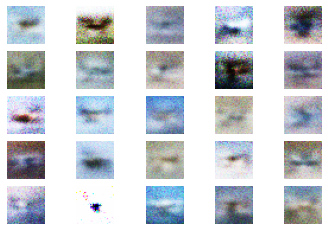

4601 [D loss: 0.366165, acc.: 86.72%] [G loss: 3.437895]
4602 [D loss: 0.500042, acc.: 73.83%] [G loss: 4.526864]
4603 [D loss: 0.666183, acc.: 69.92%] [G loss: 6.696597]
4604 [D loss: 1.443097, acc.: 54.30%] [G loss: 7.755063]
4605 [D loss: 2.151022, acc.: 35.94%] [G loss: 1.672374]
4606 [D loss: 0.364042, acc.: 83.20%] [G loss: 2.544599]
4607 [D loss: 0.610926, acc.: 73.05%] [G loss: 1.963475]
4608 [D loss: 0.454757, acc.: 78.12%] [G loss: 1.820663]
4609 [D loss: 0.419179, acc.: 80.86%] [G loss: 2.317550]
4610 [D loss: 0.376544, acc.: 83.20%] [G loss: 2.304258]
4611 [D loss: 0.413625, acc.: 80.86%] [G loss: 1.794926]
4612 [D loss: 0.425773, acc.: 82.42%] [G loss: 2.028094]
4613 [D loss: 0.390747, acc.: 85.16%] [G loss: 1.756116]
4614 [D loss: 0.377564, acc.: 84.77%] [G loss: 1.842240]
4615 [D loss: 0.419081, acc.: 82.42%] [G loss: 1.897759]
4616 [D loss: 0.411630, acc.: 80.47%] [G loss: 2.071908]
4617 [D loss: 0.442577, acc.: 77.73%] [G loss: 2.063555]
4618 [D loss: 0.362127, acc.: 8

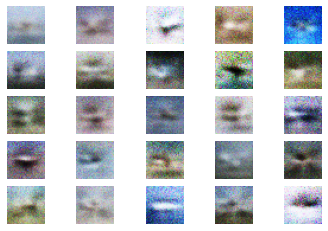

4801 [D loss: 0.359981, acc.: 82.03%] [G loss: 2.930157]
4802 [D loss: 0.299399, acc.: 86.72%] [G loss: 2.648648]
4803 [D loss: 0.343642, acc.: 85.94%] [G loss: 2.302931]
4804 [D loss: 0.384421, acc.: 82.42%] [G loss: 2.171567]
4805 [D loss: 0.358192, acc.: 88.28%] [G loss: 2.846558]
4806 [D loss: 0.393018, acc.: 79.30%] [G loss: 2.286441]
4807 [D loss: 0.340534, acc.: 85.94%] [G loss: 2.340273]
4808 [D loss: 0.332002, acc.: 85.55%] [G loss: 2.665235]
4809 [D loss: 0.308353, acc.: 90.62%] [G loss: 2.034188]
4810 [D loss: 0.286313, acc.: 92.58%] [G loss: 1.949439]
4811 [D loss: 0.352191, acc.: 88.28%] [G loss: 2.411483]
4812 [D loss: 0.334619, acc.: 87.11%] [G loss: 1.967687]
4813 [D loss: 0.397460, acc.: 82.81%] [G loss: 2.268318]
4814 [D loss: 0.337289, acc.: 86.33%] [G loss: 1.946293]
4815 [D loss: 0.375831, acc.: 84.38%] [G loss: 2.048144]
4816 [D loss: 0.339186, acc.: 91.80%] [G loss: 1.576100]
4817 [D loss: 0.340177, acc.: 86.72%] [G loss: 2.367576]
4818 [D loss: 0.339448, acc.: 8

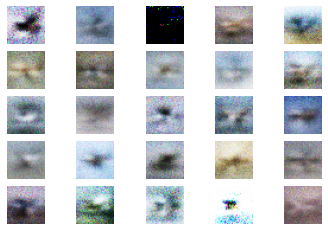

5001 [D loss: 0.370077, acc.: 83.59%] [G loss: 1.880818]
5002 [D loss: 0.343785, acc.: 85.16%] [G loss: 1.907852]
5003 [D loss: 0.300208, acc.: 90.62%] [G loss: 2.092325]
5004 [D loss: 0.401094, acc.: 84.77%] [G loss: 2.419070]
5005 [D loss: 0.316701, acc.: 89.84%] [G loss: 2.171907]
5006 [D loss: 0.415345, acc.: 81.25%] [G loss: 2.170156]
5007 [D loss: 0.403905, acc.: 80.86%] [G loss: 1.968304]
5008 [D loss: 0.356167, acc.: 85.94%] [G loss: 2.124462]
5009 [D loss: 0.444631, acc.: 76.95%] [G loss: 2.631821]
5010 [D loss: 0.444615, acc.: 77.73%] [G loss: 3.086174]
5011 [D loss: 0.444629, acc.: 80.86%] [G loss: 2.556162]
5012 [D loss: 0.362348, acc.: 85.55%] [G loss: 2.292135]
5013 [D loss: 0.307875, acc.: 89.84%] [G loss: 2.139633]
5014 [D loss: 0.359180, acc.: 88.28%] [G loss: 1.860802]
5015 [D loss: 0.359726, acc.: 86.72%] [G loss: 2.152450]
5016 [D loss: 0.361910, acc.: 85.16%] [G loss: 2.198281]
5017 [D loss: 0.321905, acc.: 86.33%] [G loss: 2.835864]
5018 [D loss: 0.346346, acc.: 8

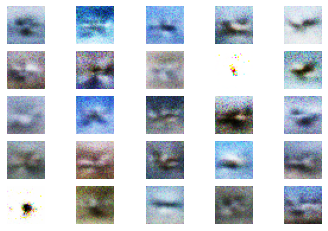

5201 [D loss: 0.382133, acc.: 80.47%] [G loss: 2.572377]
5202 [D loss: 0.348635, acc.: 85.94%] [G loss: 2.373351]
5203 [D loss: 0.366365, acc.: 87.50%] [G loss: 1.770902]
5204 [D loss: 0.350897, acc.: 87.89%] [G loss: 2.009812]
5205 [D loss: 0.348225, acc.: 85.55%] [G loss: 2.300587]
5206 [D loss: 0.369897, acc.: 83.20%] [G loss: 1.937062]
5207 [D loss: 0.393280, acc.: 82.03%] [G loss: 1.656535]
5208 [D loss: 0.342674, acc.: 87.50%] [G loss: 2.061755]
5209 [D loss: 0.400753, acc.: 82.81%] [G loss: 1.926082]
5210 [D loss: 0.383179, acc.: 83.20%] [G loss: 1.858312]
5211 [D loss: 0.403750, acc.: 84.77%] [G loss: 1.830842]
5212 [D loss: 0.366440, acc.: 88.67%] [G loss: 2.179069]
5213 [D loss: 0.356719, acc.: 85.94%] [G loss: 2.074936]
5214 [D loss: 0.330851, acc.: 87.11%] [G loss: 2.257822]
5215 [D loss: 0.455730, acc.: 79.30%] [G loss: 1.969938]
5216 [D loss: 0.328778, acc.: 88.67%] [G loss: 1.886488]
5217 [D loss: 0.334491, acc.: 88.67%] [G loss: 2.045136]
5218 [D loss: 0.326797, acc.: 8

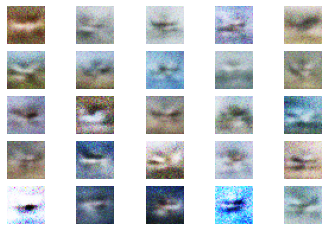

5401 [D loss: 0.370362, acc.: 85.55%] [G loss: 1.961402]
5402 [D loss: 0.330619, acc.: 86.72%] [G loss: 1.942106]
5403 [D loss: 0.407584, acc.: 82.42%] [G loss: 1.933660]
5404 [D loss: 0.385560, acc.: 82.42%] [G loss: 1.716502]
5405 [D loss: 0.358717, acc.: 86.33%] [G loss: 1.977266]
5406 [D loss: 0.383609, acc.: 85.16%] [G loss: 2.224137]
5407 [D loss: 0.338766, acc.: 87.11%] [G loss: 1.952718]
5408 [D loss: 0.397304, acc.: 83.59%] [G loss: 2.441291]
5409 [D loss: 0.320812, acc.: 89.45%] [G loss: 2.600087]
5410 [D loss: 0.378481, acc.: 84.38%] [G loss: 2.135188]
5411 [D loss: 0.364544, acc.: 86.33%] [G loss: 1.993293]
5412 [D loss: 0.377106, acc.: 85.16%] [G loss: 2.142138]
5413 [D loss: 0.381501, acc.: 84.38%] [G loss: 2.030446]
5414 [D loss: 0.399940, acc.: 82.03%] [G loss: 1.772590]
5415 [D loss: 0.428480, acc.: 82.81%] [G loss: 2.593865]
5416 [D loss: 0.373348, acc.: 85.16%] [G loss: 2.200981]
5417 [D loss: 0.417355, acc.: 80.47%] [G loss: 1.965299]
5418 [D loss: 0.309301, acc.: 8

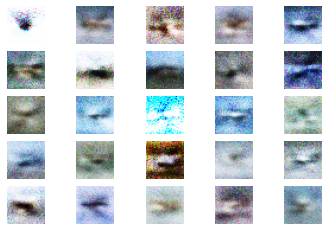

5601 [D loss: 0.329709, acc.: 88.67%] [G loss: 2.320035]
5602 [D loss: 0.357284, acc.: 85.16%] [G loss: 2.154617]
5603 [D loss: 0.365990, acc.: 84.38%] [G loss: 2.292502]
5604 [D loss: 0.384700, acc.: 83.98%] [G loss: 2.084260]
5605 [D loss: 0.422996, acc.: 82.42%] [G loss: 2.068617]
5606 [D loss: 0.389398, acc.: 83.98%] [G loss: 1.770514]
5607 [D loss: 0.369171, acc.: 83.59%] [G loss: 1.839347]
5608 [D loss: 0.391481, acc.: 82.81%] [G loss: 2.861305]
5609 [D loss: 0.406700, acc.: 80.86%] [G loss: 2.407236]
5610 [D loss: 0.352690, acc.: 86.72%] [G loss: 2.095615]
5611 [D loss: 0.375519, acc.: 85.16%] [G loss: 1.947875]
5612 [D loss: 0.344411, acc.: 87.89%] [G loss: 1.937000]
5613 [D loss: 0.354390, acc.: 88.28%] [G loss: 2.096381]
5614 [D loss: 0.414258, acc.: 82.03%] [G loss: 1.748898]
5615 [D loss: 0.375472, acc.: 83.20%] [G loss: 2.319752]
5616 [D loss: 0.407907, acc.: 82.42%] [G loss: 2.427985]
5617 [D loss: 0.385965, acc.: 82.81%] [G loss: 2.211610]
5618 [D loss: 0.371820, acc.: 8

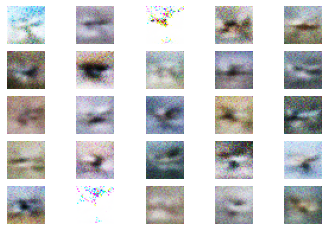

5801 [D loss: 0.367892, acc.: 83.98%] [G loss: 2.191063]
5802 [D loss: 0.356068, acc.: 85.94%] [G loss: 2.217649]
5803 [D loss: 0.406476, acc.: 82.03%] [G loss: 1.972200]
5804 [D loss: 0.381354, acc.: 85.16%] [G loss: 1.856991]
5805 [D loss: 0.360368, acc.: 85.55%] [G loss: 2.352307]
5806 [D loss: 0.375976, acc.: 85.16%] [G loss: 2.185604]
5807 [D loss: 0.315703, acc.: 89.45%] [G loss: 2.130393]
5808 [D loss: 0.408790, acc.: 82.03%] [G loss: 2.106042]
5809 [D loss: 0.375635, acc.: 83.98%] [G loss: 2.098993]
5810 [D loss: 0.402855, acc.: 83.20%] [G loss: 1.925490]
5811 [D loss: 0.310866, acc.: 88.28%] [G loss: 1.834876]
5812 [D loss: 0.361494, acc.: 85.55%] [G loss: 1.908014]
5813 [D loss: 0.370117, acc.: 84.38%] [G loss: 2.093930]
5814 [D loss: 0.372827, acc.: 85.16%] [G loss: 1.970202]
5815 [D loss: 0.339335, acc.: 85.55%] [G loss: 2.012829]
5816 [D loss: 0.424215, acc.: 80.86%] [G loss: 1.845212]
5817 [D loss: 0.367671, acc.: 87.89%] [G loss: 1.810028]
5818 [D loss: 0.401785, acc.: 8

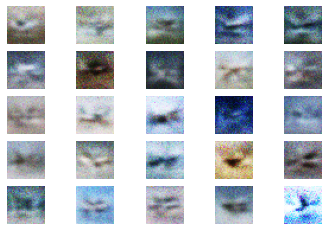

6001 [D loss: 0.323897, acc.: 87.50%] [G loss: 3.151687]
6002 [D loss: 0.378612, acc.: 83.98%] [G loss: 2.505384]
6003 [D loss: 0.362825, acc.: 85.94%] [G loss: 1.939459]
6004 [D loss: 0.359214, acc.: 83.59%] [G loss: 2.555882]
6005 [D loss: 0.333564, acc.: 83.98%] [G loss: 2.090281]
6006 [D loss: 0.405464, acc.: 82.81%] [G loss: 2.040490]
6007 [D loss: 0.386088, acc.: 82.81%] [G loss: 2.093371]
6008 [D loss: 0.340506, acc.: 87.11%] [G loss: 2.052712]
6009 [D loss: 0.393350, acc.: 82.42%] [G loss: 2.333875]
6010 [D loss: 0.433228, acc.: 82.81%] [G loss: 2.311141]
6011 [D loss: 0.305152, acc.: 90.62%] [G loss: 2.712496]
6012 [D loss: 0.318804, acc.: 89.06%] [G loss: 1.815426]
6013 [D loss: 0.350053, acc.: 84.77%] [G loss: 2.188292]
6014 [D loss: 0.313754, acc.: 89.06%] [G loss: 2.501312]
6015 [D loss: 0.319802, acc.: 87.11%] [G loss: 2.416129]
6016 [D loss: 0.406728, acc.: 84.38%] [G loss: 2.104507]
6017 [D loss: 0.320274, acc.: 87.50%] [G loss: 2.125216]
6018 [D loss: 0.404647, acc.: 8

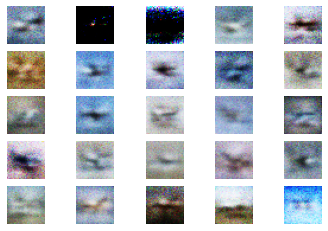

6201 [D loss: 0.593988, acc.: 64.84%] [G loss: 7.040080]
6202 [D loss: 0.514972, acc.: 78.52%] [G loss: 7.327553]
6203 [D loss: 0.317260, acc.: 85.55%] [G loss: 3.538068]
6204 [D loss: 0.324340, acc.: 84.38%] [G loss: 2.558338]
6205 [D loss: 0.260306, acc.: 91.02%] [G loss: 2.751364]
6206 [D loss: 0.333011, acc.: 87.11%] [G loss: 2.441967]
6207 [D loss: 0.419522, acc.: 78.12%] [G loss: 3.196008]
6208 [D loss: 0.412892, acc.: 82.03%] [G loss: 2.271633]
6209 [D loss: 0.363167, acc.: 84.77%] [G loss: 2.557253]
6210 [D loss: 0.313754, acc.: 88.28%] [G loss: 2.648734]
6211 [D loss: 0.391819, acc.: 83.20%] [G loss: 2.552717]
6212 [D loss: 0.416800, acc.: 79.30%] [G loss: 3.159158]
6213 [D loss: 0.349431, acc.: 86.33%] [G loss: 2.536539]
6214 [D loss: 0.421477, acc.: 79.30%] [G loss: 2.321010]
6215 [D loss: 0.396806, acc.: 84.38%] [G loss: 2.078265]
6216 [D loss: 0.325991, acc.: 86.33%] [G loss: 2.389866]
6217 [D loss: 0.354490, acc.: 85.94%] [G loss: 2.086395]
6218 [D loss: 0.388681, acc.: 8

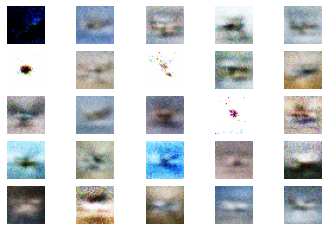

6401 [D loss: 0.327129, acc.: 87.11%] [G loss: 2.207788]
6402 [D loss: 0.355377, acc.: 85.16%] [G loss: 2.159671]
6403 [D loss: 0.359189, acc.: 87.11%] [G loss: 2.030581]
6404 [D loss: 0.369786, acc.: 85.55%] [G loss: 1.848837]
6405 [D loss: 0.366267, acc.: 85.94%] [G loss: 2.038299]
6406 [D loss: 0.370636, acc.: 84.77%] [G loss: 2.513719]
6407 [D loss: 0.412941, acc.: 82.42%] [G loss: 2.551977]
6408 [D loss: 0.327852, acc.: 84.77%] [G loss: 4.992977]
6409 [D loss: 0.349260, acc.: 83.20%] [G loss: 2.647308]
6410 [D loss: 0.308432, acc.: 86.33%] [G loss: 2.907885]
6411 [D loss: 0.343050, acc.: 82.03%] [G loss: 4.551943]
6412 [D loss: 0.233539, acc.: 90.23%] [G loss: 5.119919]
6413 [D loss: 0.288245, acc.: 89.45%] [G loss: 3.632220]
6414 [D loss: 0.256055, acc.: 91.02%] [G loss: 3.135696]
6415 [D loss: 0.261749, acc.: 89.84%] [G loss: 3.970059]
6416 [D loss: 0.309608, acc.: 87.89%] [G loss: 2.763204]
6417 [D loss: 0.345553, acc.: 84.38%] [G loss: 2.384799]
6418 [D loss: 0.360118, acc.: 8

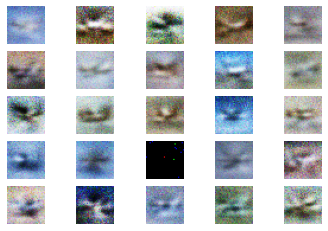

6601 [D loss: 0.360746, acc.: 85.94%] [G loss: 2.545610]
6602 [D loss: 0.365314, acc.: 84.38%] [G loss: 2.155633]
6603 [D loss: 0.354284, acc.: 87.50%] [G loss: 1.980502]
6604 [D loss: 0.385701, acc.: 83.59%] [G loss: 2.235086]
6605 [D loss: 0.409243, acc.: 79.30%] [G loss: 2.014453]
6606 [D loss: 0.308020, acc.: 91.02%] [G loss: 2.174471]
6607 [D loss: 0.336255, acc.: 89.45%] [G loss: 2.206208]
6608 [D loss: 0.465425, acc.: 76.95%] [G loss: 1.983916]
6609 [D loss: 0.339316, acc.: 88.67%] [G loss: 2.179646]
6610 [D loss: 0.373557, acc.: 83.59%] [G loss: 2.068299]
6611 [D loss: 0.291541, acc.: 91.41%] [G loss: 2.547620]
6612 [D loss: 0.320744, acc.: 87.50%] [G loss: 2.354228]
6613 [D loss: 0.317717, acc.: 89.45%] [G loss: 2.206998]
6614 [D loss: 0.271644, acc.: 90.62%] [G loss: 2.525435]
6615 [D loss: 0.358261, acc.: 85.16%] [G loss: 2.165352]
6616 [D loss: 0.306410, acc.: 87.11%] [G loss: 2.393732]
6617 [D loss: 0.372669, acc.: 84.77%] [G loss: 1.988804]
6618 [D loss: 0.366883, acc.: 8

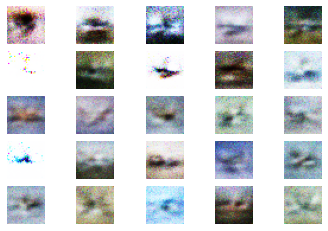

6801 [D loss: 0.422483, acc.: 82.42%] [G loss: 5.156690]
6802 [D loss: 0.588663, acc.: 72.66%] [G loss: 5.161425]
6803 [D loss: 1.121385, acc.: 55.47%] [G loss: 4.823866]
6804 [D loss: 0.854600, acc.: 64.45%] [G loss: 3.629354]
6805 [D loss: 0.335196, acc.: 84.38%] [G loss: 3.342660]
6806 [D loss: 0.394783, acc.: 83.20%] [G loss: 3.145610]
6807 [D loss: 0.305774, acc.: 89.45%] [G loss: 2.635669]
6808 [D loss: 0.306157, acc.: 88.28%] [G loss: 2.402280]
6809 [D loss: 0.271278, acc.: 93.36%] [G loss: 2.178450]
6810 [D loss: 0.303047, acc.: 89.45%] [G loss: 2.051861]
6811 [D loss: 0.348462, acc.: 87.11%] [G loss: 2.181877]
6812 [D loss: 0.293552, acc.: 87.11%] [G loss: 2.717166]
6813 [D loss: 0.326494, acc.: 87.50%] [G loss: 2.833943]
6814 [D loss: 0.413771, acc.: 81.25%] [G loss: 2.233945]
6815 [D loss: 0.336991, acc.: 84.77%] [G loss: 2.292906]
6816 [D loss: 0.305741, acc.: 91.02%] [G loss: 2.398721]
6817 [D loss: 0.349112, acc.: 86.72%] [G loss: 2.301723]
6818 [D loss: 0.306676, acc.: 8

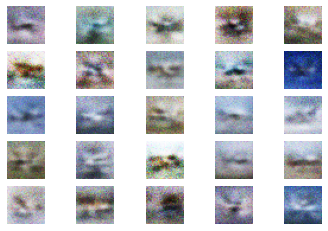

7001 [D loss: 0.370114, acc.: 84.77%] [G loss: 2.340296]
7002 [D loss: 0.357648, acc.: 85.94%] [G loss: 2.230133]
7003 [D loss: 0.374820, acc.: 83.59%] [G loss: 2.832433]
7004 [D loss: 0.366600, acc.: 80.47%] [G loss: 4.123926]
7005 [D loss: 0.527613, acc.: 71.88%] [G loss: 4.777451]
7006 [D loss: 0.719790, acc.: 66.02%] [G loss: 6.949708]
7007 [D loss: 1.547306, acc.: 45.31%] [G loss: 5.492433]
7008 [D loss: 1.752093, acc.: 46.48%] [G loss: 2.291013]
7009 [D loss: 0.651813, acc.: 71.88%] [G loss: 3.136381]
7010 [D loss: 0.559104, acc.: 75.78%] [G loss: 2.598599]
7011 [D loss: 0.407323, acc.: 85.55%] [G loss: 3.500432]
7012 [D loss: 0.379503, acc.: 84.38%] [G loss: 2.586262]
7013 [D loss: 0.361097, acc.: 83.98%] [G loss: 2.499335]
7014 [D loss: 0.341929, acc.: 84.38%] [G loss: 2.753242]
7015 [D loss: 0.334108, acc.: 83.98%] [G loss: 2.188241]
7016 [D loss: 0.345009, acc.: 87.11%] [G loss: 2.168606]
7017 [D loss: 0.358974, acc.: 83.20%] [G loss: 2.146433]
7018 [D loss: 0.314064, acc.: 8

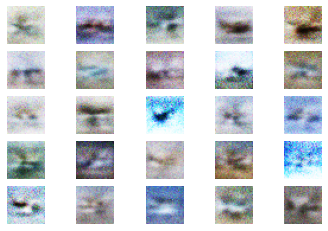

7201 [D loss: 0.300822, acc.: 89.45%] [G loss: 2.520120]
7202 [D loss: 0.326729, acc.: 87.50%] [G loss: 2.059250]
7203 [D loss: 0.387502, acc.: 84.38%] [G loss: 2.048377]
7204 [D loss: 0.408299, acc.: 82.42%] [G loss: 2.068795]
7205 [D loss: 0.350848, acc.: 83.98%] [G loss: 2.442955]
7206 [D loss: 0.436690, acc.: 78.12%] [G loss: 2.064068]
7207 [D loss: 0.317710, acc.: 86.72%] [G loss: 2.370097]
7208 [D loss: 0.334464, acc.: 87.50%] [G loss: 2.245627]
7209 [D loss: 0.347125, acc.: 85.16%] [G loss: 2.638547]
7210 [D loss: 0.378218, acc.: 83.20%] [G loss: 2.255464]
7211 [D loss: 0.337936, acc.: 86.33%] [G loss: 2.162945]
7212 [D loss: 0.251683, acc.: 89.45%] [G loss: 2.674298]
7213 [D loss: 0.335184, acc.: 84.38%] [G loss: 3.100673]
7214 [D loss: 0.284779, acc.: 85.55%] [G loss: 2.953458]
7215 [D loss: 0.313029, acc.: 88.28%] [G loss: 3.992074]
7216 [D loss: 0.248056, acc.: 88.67%] [G loss: 3.653207]
7217 [D loss: 0.274871, acc.: 89.45%] [G loss: 3.417458]
7218 [D loss: 0.306795, acc.: 9

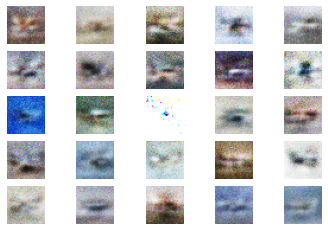

7401 [D loss: 0.270474, acc.: 91.02%] [G loss: 2.271208]
7402 [D loss: 0.244241, acc.: 90.23%] [G loss: 2.125236]
7403 [D loss: 0.334984, acc.: 87.89%] [G loss: 2.767245]
7404 [D loss: 0.339978, acc.: 87.11%] [G loss: 2.282130]
7405 [D loss: 0.321889, acc.: 85.94%] [G loss: 2.241343]
7406 [D loss: 0.354455, acc.: 85.94%] [G loss: 2.551420]
7407 [D loss: 0.322469, acc.: 86.72%] [G loss: 2.569132]
7408 [D loss: 0.363556, acc.: 83.59%] [G loss: 2.951459]
7409 [D loss: 0.348718, acc.: 85.94%] [G loss: 2.329273]
7410 [D loss: 0.329612, acc.: 85.55%] [G loss: 2.334254]
7411 [D loss: 0.286419, acc.: 88.67%] [G loss: 3.741756]
7412 [D loss: 0.337224, acc.: 85.94%] [G loss: 3.149543]
7413 [D loss: 0.314279, acc.: 90.23%] [G loss: 2.241908]
7414 [D loss: 0.411719, acc.: 82.03%] [G loss: 2.685380]
7415 [D loss: 0.403648, acc.: 82.81%] [G loss: 2.592549]
7416 [D loss: 0.368662, acc.: 83.98%] [G loss: 1.947807]
7417 [D loss: 0.292220, acc.: 91.80%] [G loss: 2.560481]
7418 [D loss: 0.367320, acc.: 8

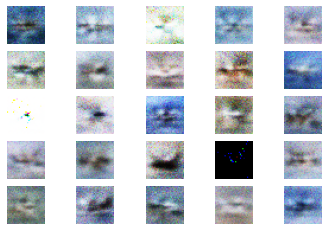

7601 [D loss: 0.284439, acc.: 89.06%] [G loss: 4.209413]
7602 [D loss: 0.372735, acc.: 82.03%] [G loss: 3.220942]
7603 [D loss: 0.283253, acc.: 87.89%] [G loss: 3.615345]
7604 [D loss: 0.266640, acc.: 90.23%] [G loss: 3.019684]
7605 [D loss: 0.350201, acc.: 82.03%] [G loss: 2.870077]
7606 [D loss: 0.315807, acc.: 87.11%] [G loss: 3.179302]
7607 [D loss: 0.251473, acc.: 91.80%] [G loss: 2.762055]
7608 [D loss: 0.391258, acc.: 82.81%] [G loss: 2.500256]
7609 [D loss: 0.361670, acc.: 86.33%] [G loss: 2.133858]
7610 [D loss: 0.397956, acc.: 82.81%] [G loss: 2.286997]
7611 [D loss: 0.425132, acc.: 79.30%] [G loss: 2.575167]
7612 [D loss: 0.316279, acc.: 87.11%] [G loss: 2.728565]
7613 [D loss: 0.387434, acc.: 83.59%] [G loss: 2.790279]
7614 [D loss: 0.358383, acc.: 85.94%] [G loss: 2.560604]
7615 [D loss: 0.408616, acc.: 83.98%] [G loss: 2.278139]
7616 [D loss: 0.355295, acc.: 84.77%] [G loss: 3.016155]
7617 [D loss: 0.310932, acc.: 85.94%] [G loss: 3.860617]
7618 [D loss: 0.231090, acc.: 9

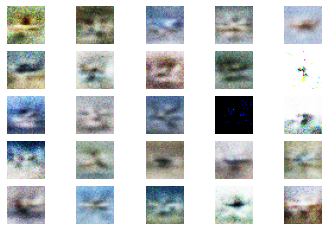

7801 [D loss: 0.345673, acc.: 85.16%] [G loss: 2.344774]
7802 [D loss: 0.254478, acc.: 90.62%] [G loss: 3.027349]
7803 [D loss: 0.275183, acc.: 89.45%] [G loss: 2.990300]
7804 [D loss: 0.314608, acc.: 88.67%] [G loss: 2.490044]
7805 [D loss: 0.235371, acc.: 91.41%] [G loss: 4.616966]
7806 [D loss: 0.328315, acc.: 86.33%] [G loss: 2.780397]
7807 [D loss: 0.287844, acc.: 89.84%] [G loss: 3.380656]
7808 [D loss: 0.263460, acc.: 92.58%] [G loss: 2.933879]
7809 [D loss: 0.307212, acc.: 88.28%] [G loss: 2.498927]
7810 [D loss: 0.316886, acc.: 86.33%] [G loss: 3.100426]
7811 [D loss: 0.321335, acc.: 85.55%] [G loss: 2.285465]
7812 [D loss: 0.342306, acc.: 85.94%] [G loss: 2.378534]
7813 [D loss: 0.350392, acc.: 87.50%] [G loss: 2.424417]
7814 [D loss: 0.309731, acc.: 89.45%] [G loss: 2.387074]
7815 [D loss: 0.355896, acc.: 85.94%] [G loss: 2.224871]
7816 [D loss: 0.340316, acc.: 87.89%] [G loss: 2.043766]
7817 [D loss: 0.291798, acc.: 91.02%] [G loss: 2.214149]
7818 [D loss: 0.332442, acc.: 8

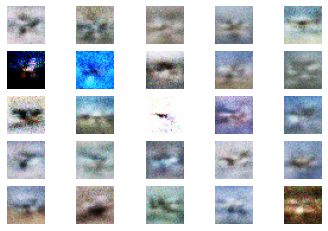

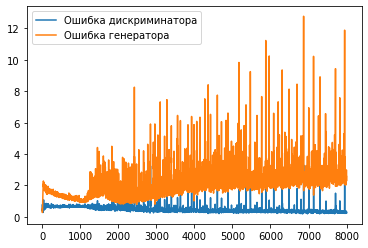

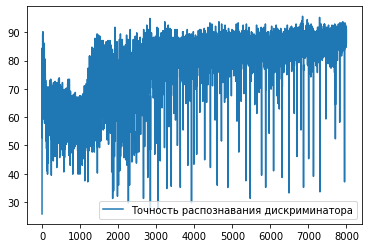

In [12]:
train_cifar(generator_cifar, discriminator_cifar, 8000) # Вызываем функцию train_cifar с параметрами: generator_cifar, discriminator_cifar, 8000 (8000 - количество эпох)

как мы видим, что ничего не видим)) работает плохо

# Эксперимент №2

возьмем архитектуру InfoGAN, которую все советуют и проведем с ней эксперименты  
https://arxiv.org/abs/1606.03657

In [13]:
# Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
gen = Sequential()

gen.add(Dense(128 * 8 * 8, input_dim=latent_dim))
gen.add(Reshape((8, 8, 128)))
gen.add(BatchNormalization(momentum=0.8))
gen.add(ReLU()),
gen.add(UpSampling2D())
gen.add(Conv2D(128, kernel_size=3, padding="same"))
gen.add(BatchNormalization(momentum=0.8))
gen.add(ReLU()),
gen.add(UpSampling2D())
gen.add(Conv2D(64, kernel_size=3, padding="same"))
gen.add(BatchNormalization(momentum=0.8))
gen.add(ReLU()),
gen.add(Conv2D(channels, kernel_size=3, padding='same', activation='tanh'))

gen_input = Input(shape=(latent_dim,))
img = gen(gen_input)

gen.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)      

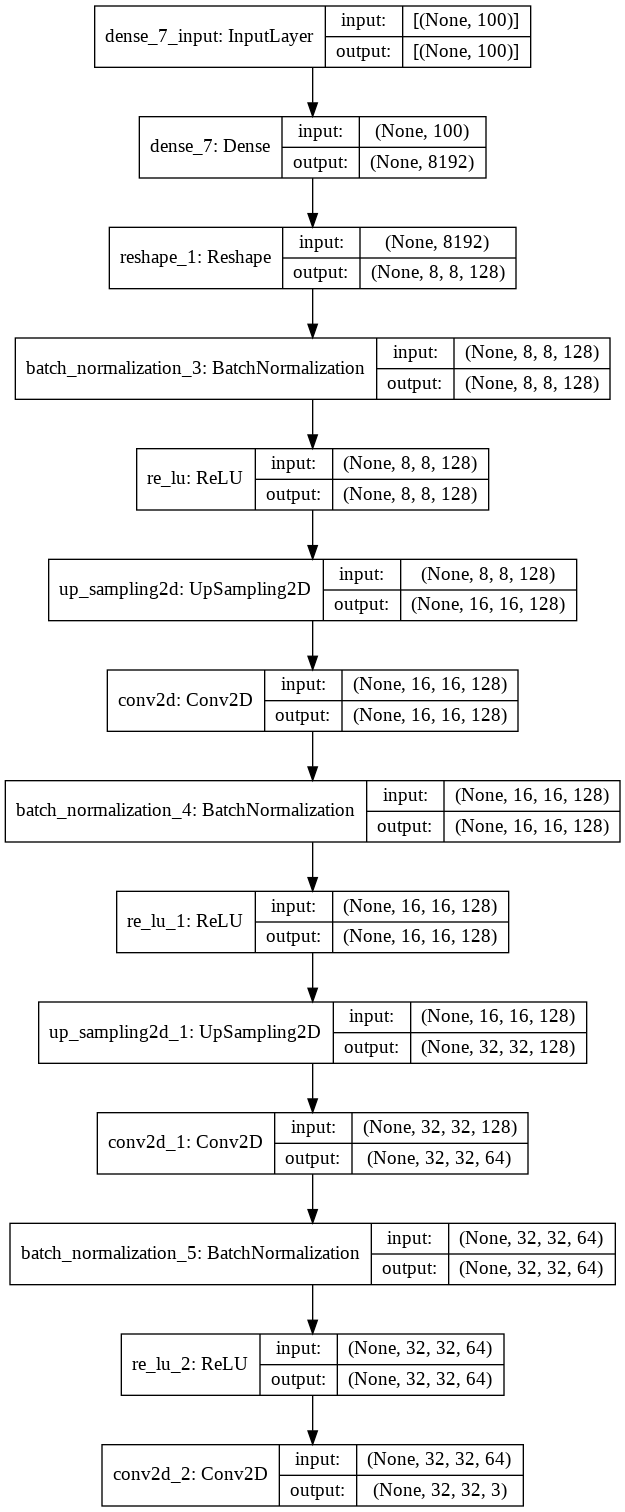

In [14]:
tf.keras.utils.plot_model(gen, show_shapes=True)

In [15]:
img = Input(shape=img_shape)

model = Sequential()
model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
model.add(ZeroPadding2D(padding=((0,1),(0,1))))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(BatchNormalization(momentum=0.8))
model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(BatchNormalization(momentum=0.8))
model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(BatchNormalization(momentum=0.8))
model.add(Flatten())

img_embedding = model(img)

# Discriminator
validity = Dense(1, activation='sigmoid')(img_embedding)
d = Model(img, validity)
 # Компилируем модель дискриманотра
d.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

d.trainable = False # Замораживаем обучение дискриматора 

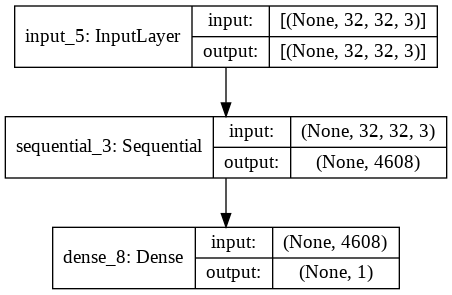

In [16]:
tf.keras.utils.plot_model(d, show_shapes=True)

0 [D loss: 9.931420, acc.: 24.22%] [G loss: 1.589859]


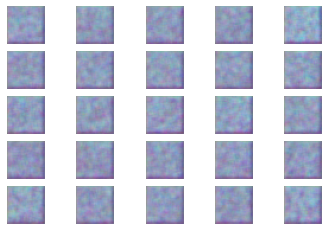

1 [D loss: 15.478990, acc.: 12.50%] [G loss: 3.005895]
2 [D loss: 11.004941, acc.: 42.19%] [G loss: 0.007882]
3 [D loss: 0.262357, acc.: 91.41%] [G loss: 0.234030]
4 [D loss: 3.385963, acc.: 45.70%] [G loss: 0.127535]
5 [D loss: 0.152931, acc.: 91.80%] [G loss: 0.119002]
6 [D loss: 0.207710, acc.: 89.84%] [G loss: 0.029280]
7 [D loss: 0.148210, acc.: 93.75%] [G loss: 0.015361]
8 [D loss: 0.112998, acc.: 96.48%] [G loss: 0.031635]
9 [D loss: 0.041027, acc.: 99.22%] [G loss: 0.069311]
10 [D loss: 0.042246, acc.: 99.22%] [G loss: 0.141048]
11 [D loss: 0.024053, acc.: 99.61%] [G loss: 0.193913]
12 [D loss: 0.025875, acc.: 99.61%] [G loss: 0.294489]
13 [D loss: 0.026666, acc.: 100.00%] [G loss: 0.300830]
14 [D loss: 0.024602, acc.: 99.61%] [G loss: 0.194187]
15 [D loss: 0.025251, acc.: 100.00%] [G loss: 0.109994]
16 [D loss: 0.017366, acc.: 100.00%] [G loss: 0.049742]
17 [D loss: 0.016003, acc.: 100.00%] [G loss: 0.027673]
18 [D loss: 0.013882, acc.: 100.00%] [G loss: 0.021138]
19 [D loss: 

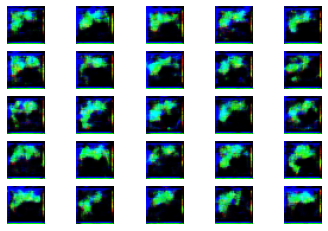

201 [D loss: 0.000830, acc.: 100.00%] [G loss: 0.003131]
202 [D loss: 0.000812, acc.: 100.00%] [G loss: 0.003576]
203 [D loss: 0.000753, acc.: 100.00%] [G loss: 0.003314]
204 [D loss: 0.001036, acc.: 100.00%] [G loss: 0.003412]
205 [D loss: 0.001020, acc.: 100.00%] [G loss: 0.003063]
206 [D loss: 0.001086, acc.: 100.00%] [G loss: 0.003718]
207 [D loss: 0.000660, acc.: 100.00%] [G loss: 0.003698]
208 [D loss: 0.000596, acc.: 100.00%] [G loss: 0.002664]
209 [D loss: 0.000737, acc.: 100.00%] [G loss: 0.002791]
210 [D loss: 0.000500, acc.: 100.00%] [G loss: 0.003315]
211 [D loss: 0.001098, acc.: 100.00%] [G loss: 0.004080]
212 [D loss: 0.000887, acc.: 100.00%] [G loss: 0.003565]
213 [D loss: 0.000559, acc.: 100.00%] [G loss: 0.004530]
214 [D loss: 0.000861, acc.: 100.00%] [G loss: 0.005224]
215 [D loss: 0.001238, acc.: 100.00%] [G loss: 0.003957]
216 [D loss: 0.000871, acc.: 100.00%] [G loss: 0.004596]
217 [D loss: 0.000639, acc.: 100.00%] [G loss: 0.004039]
218 [D loss: 0.000975, acc.: 10

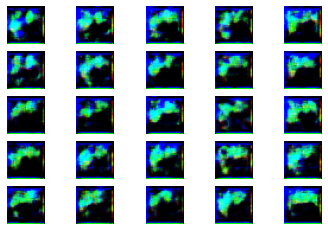

401 [D loss: 0.000433, acc.: 100.00%] [G loss: 0.002995]
402 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.002029]
403 [D loss: 0.000322, acc.: 100.00%] [G loss: 0.001928]
404 [D loss: 0.000364, acc.: 100.00%] [G loss: 0.002360]
405 [D loss: 0.000426, acc.: 100.00%] [G loss: 0.002613]
406 [D loss: 0.000441, acc.: 100.00%] [G loss: 0.003000]
407 [D loss: 0.000315, acc.: 100.00%] [G loss: 0.002495]
408 [D loss: 0.000429, acc.: 100.00%] [G loss: 0.002111]
409 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.002114]
410 [D loss: 0.000372, acc.: 100.00%] [G loss: 0.001711]
411 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.001879]
412 [D loss: 0.000266, acc.: 100.00%] [G loss: 0.001646]
413 [D loss: 0.000524, acc.: 100.00%] [G loss: 0.002364]
414 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.002619]
415 [D loss: 0.000293, acc.: 100.00%] [G loss: 0.002111]
416 [D loss: 0.000373, acc.: 100.00%] [G loss: 0.002565]
417 [D loss: 0.000290, acc.: 100.00%] [G loss: 0.001677]
418 [D loss: 0.000389, acc.: 10

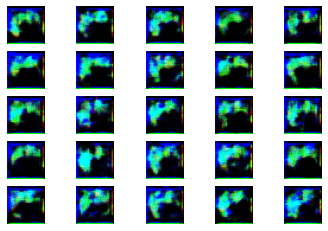

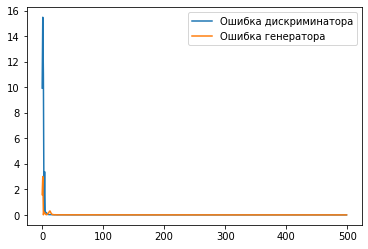

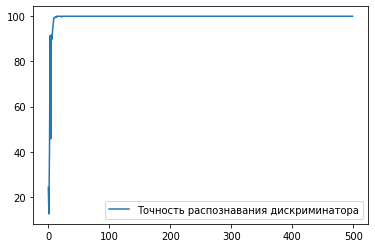

In [17]:
train_cifar(gen, d, 500, 128) # Вызываем функцию train_cifar с параметрами: generator_cifar, discriminator_cifar

как мы видим, точность очень быстро становится 100% и генератор ничего хорошего сгенерировать не может.

# Эксперимент №3

попробуем усилить генератор

In [18]:
# Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
gen_2 = Sequential()

gen_2.add(Dense(256 * 8 * 8, input_dim=latent_dim))
gen_2.add(Reshape((8, 8, 256)))
gen_2.add(BatchNormalization(momentum=0.8))
gen_2.add(ReLU()),
gen_2.add(UpSampling2D())
gen_2.add(Conv2D(256, kernel_size=3, padding="same"))
gen_2.add(BatchNormalization(momentum=0.8))
gen_2.add(ReLU()),
gen_2.add(UpSampling2D())
gen_2.add(Conv2D(128, kernel_size=3, padding="same"))
gen_2.add(BatchNormalization(momentum=0.8))
gen_2.add(ReLU()),
gen_2.add(UpSampling2D())
gen_2.add(Conv2D(64, kernel_size=3, padding="same"))
gen_2.add(BatchNormalization(momentum=0.8))
gen_2.add(ReLU()),
gen_2.add(Conv2D(channels, kernel_size=3, padding='same', activation='tanh'))
gen_2.add(MaxPooling2D())

gen_input = Input(shape=(latent_dim,))
img = gen_2(gen_input)

gen_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 256)      

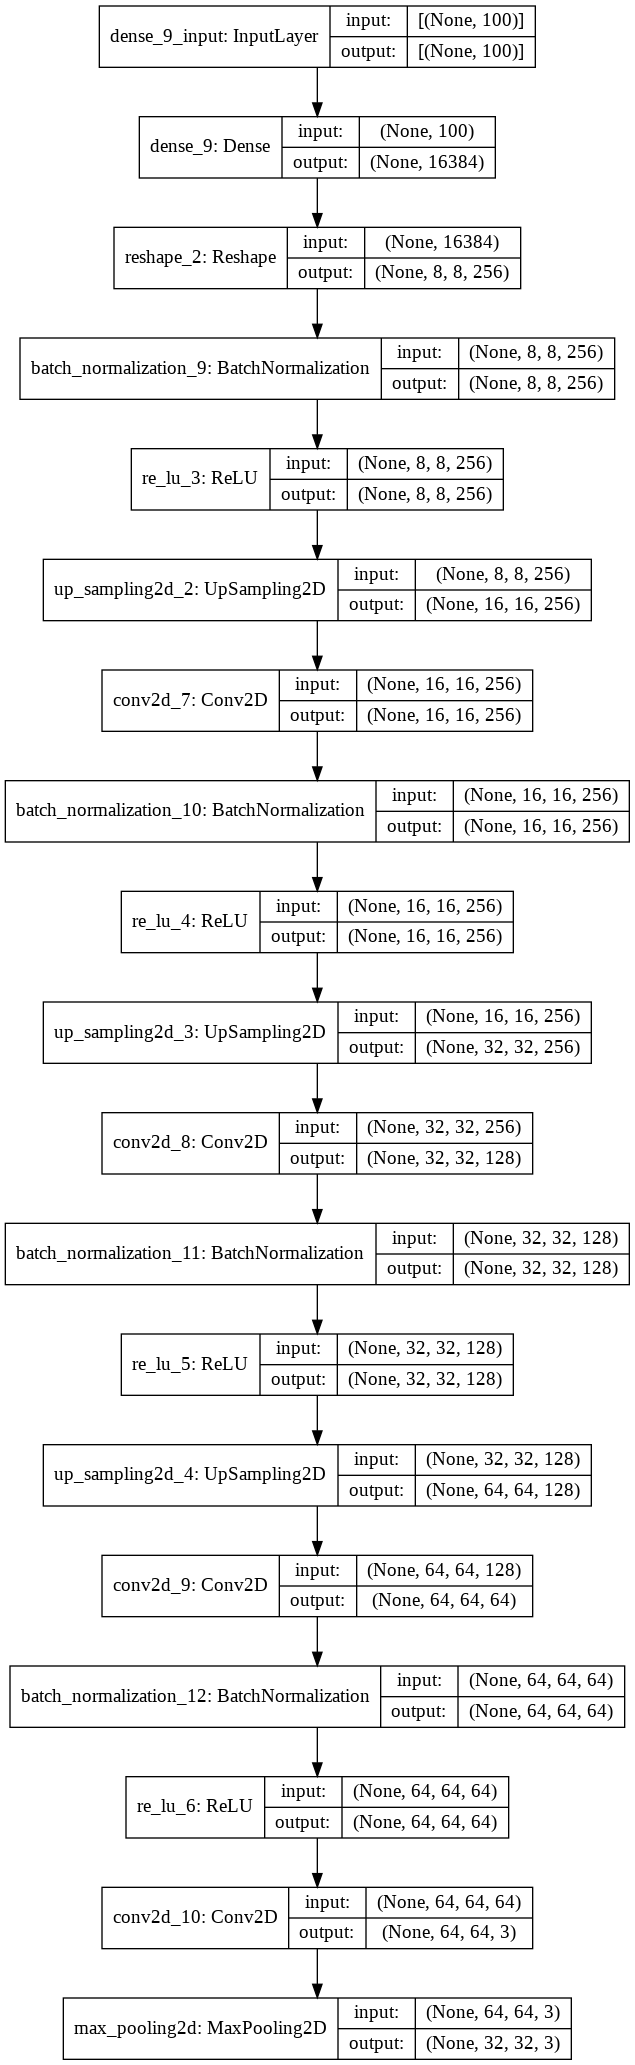

In [19]:
tf.keras.utils.plot_model(gen_2, show_shapes=True)

0 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.001938]


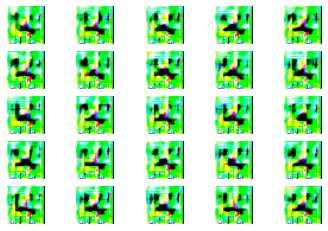

1 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.003900]
2 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.003130]
3 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.004551]
4 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.002330]
5 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.001035]
6 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.002667]
7 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.001186]
8 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.001371]
9 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.001201]
10 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.001973]
11 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.002381]
12 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000989]
13 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.001620]
14 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.001437]
15 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.001190]
16 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.001140]
17 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.001110]
18 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.001241]
1

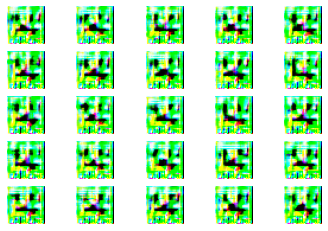

201 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.001971]
202 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.002062]
203 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.003228]
204 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.003152]
205 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.002389]
206 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.006003]
207 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.013342]
208 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.006688]
209 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.011177]
210 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.005267]
211 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.007996]
212 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.004372]
213 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.003747]
214 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.005253]
215 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.002579]
216 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.005295]
217 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.002320]
218 [D loss: 0.000005, acc.: 10

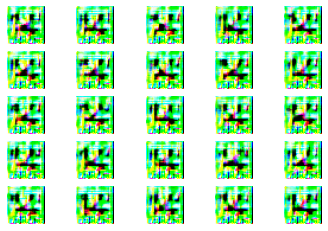

401 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.002886]
402 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.001322]
403 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.000736]
404 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.000964]
405 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000913]
406 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.000495]
407 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.000550]
408 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000442]
409 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000700]
410 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000965]
411 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000374]
412 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000646]
413 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.001886]
414 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000630]
415 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000987]
416 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.001104]
417 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000899]
418 [D loss: 0.000002, acc.: 10

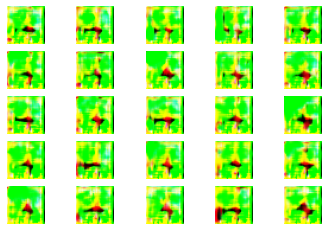

601 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.949497]
602 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.288298]
603 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.621318]
604 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.451188]
605 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.358109]
606 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.376716]
607 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.391508]
608 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.214526]
609 [D loss: 0.000002, acc.: 100.00%] [G loss: 1.512699]
610 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.798378]
611 [D loss: 0.000002, acc.: 100.00%] [G loss: 1.769742]
612 [D loss: 0.000004, acc.: 100.00%] [G loss: 1.775849]
613 [D loss: 0.000002, acc.: 100.00%] [G loss: 1.521963]
614 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.460769]
615 [D loss: 0.000001, acc.: 100.00%] [G loss: 1.156136]
616 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.802989]
617 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.627044]
618 [D loss: 0.000003, acc.: 10

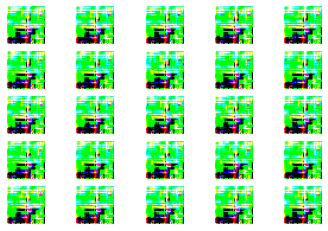

801 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.042747]
802 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.066420]
803 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.064291]
804 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.044186]
805 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.073305]
806 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.074798]
807 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.053759]
808 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.059660]
809 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.042199]
810 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.044036]
811 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.039000]
812 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.042006]
813 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.058280]
814 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.062007]
815 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.059527]
816 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.086576]
817 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.094778]
818 [D loss: 0.000004, acc.: 10

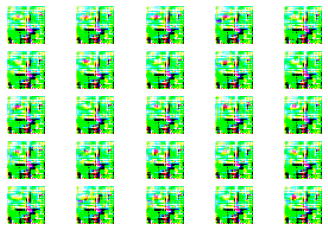

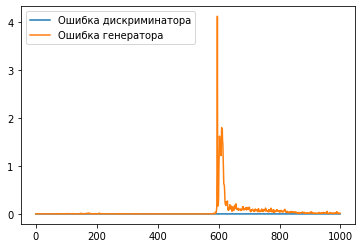

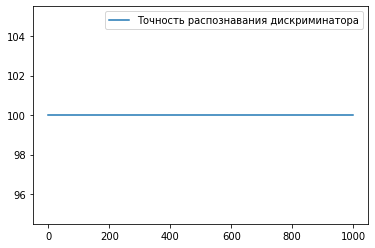

In [21]:
train_cifar(gen_2, d, 1000) # Вызываем функцию train_cifar с параметрами: generator_cifar, discriminator_cifar, 8000 (8000 - количество эпох)

аналогичная ситуация

# Эксперимент №4

попробуем ослабить дискриминатор

In [22]:
img = Input(shape=img_shape)

model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
model_2.add(LeakyReLU(alpha=0.2))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
model_2.add(ZeroPadding2D(padding=((0,1),(0,1))))
model_2.add(LeakyReLU(alpha=0.2))
model_2.add(Dropout(0.25))
model_2.add(BatchNormalization(momentum=0.8))
model_2.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
model_2.add(LeakyReLU(alpha=0.2))
model_2.add(Dropout(0.25))
model_2.add(BatchNormalization(momentum=0.8))
# model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
# model.add(LeakyReLU(alpha=0.2))
# model.add(Dropout(0.25))
# model.add(BatchNormalization(momentum=0.8))
model_2.add(Flatten())

img_embedding = model_2(img)

# Discriminator
validity = Dense(1, activation='sigmoid')(img_embedding)
d_2 = Model(img, validity)
 # Компилируем модель дискриманотра
d_2.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

d_2.trainable = False # Замораживаем обучение дискриматора 

0 [D loss: 7.550317, acc.: 29.69%] [G loss: 3.226734]


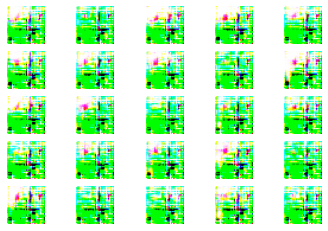

1 [D loss: 0.051892, acc.: 98.05%] [G loss: 5.064559]
2 [D loss: 0.339141, acc.: 89.84%] [G loss: 2.672881]
3 [D loss: 0.072146, acc.: 96.09%] [G loss: 2.073037]
4 [D loss: 0.010362, acc.: 100.00%] [G loss: 1.339503]
5 [D loss: 0.004311, acc.: 100.00%] [G loss: 0.328071]
6 [D loss: 0.036942, acc.: 98.83%] [G loss: 0.265079]
7 [D loss: 0.002008, acc.: 100.00%] [G loss: 0.110579]
8 [D loss: 0.006775, acc.: 100.00%] [G loss: 0.044652]
9 [D loss: 0.030648, acc.: 99.22%] [G loss: 0.972269]
10 [D loss: 0.397551, acc.: 82.81%] [G loss: 23.971346]
11 [D loss: 0.087202, acc.: 96.88%] [G loss: 21.711452]
12 [D loss: 0.115383, acc.: 96.88%] [G loss: 0.047489]
13 [D loss: 0.010726, acc.: 99.61%] [G loss: 0.001929]
14 [D loss: 0.160977, acc.: 93.36%] [G loss: 0.176088]
15 [D loss: 0.011415, acc.: 99.61%] [G loss: 0.319835]
16 [D loss: 0.022168, acc.: 99.61%] [G loss: 0.105561]
17 [D loss: 0.191075, acc.: 92.97%] [G loss: 2.039861]
18 [D loss: 0.026442, acc.: 99.61%] [G loss: 0.777987]
19 [D loss: 1

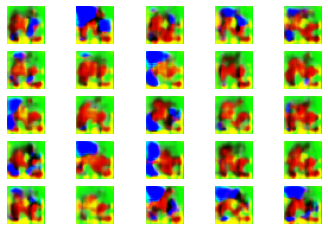

201 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.001115]
202 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.000609]
203 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.000923]
204 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.001180]
205 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.000510]
206 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.000721]
207 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.000451]
208 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.000507]
209 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.000460]
210 [D loss: 0.000297, acc.: 100.00%] [G loss: 0.000688]
211 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.000339]
212 [D loss: 0.000351, acc.: 100.00%] [G loss: 0.000839]
213 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.000449]
214 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.000237]
215 [D loss: 0.000254, acc.: 100.00%] [G loss: 0.000950]
216 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.000454]
217 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.000980]
218 [D loss: 0.000657, acc.: 10

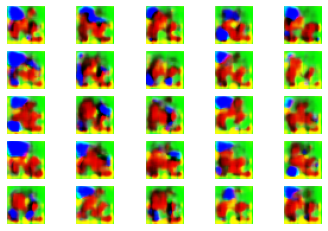

401 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.000508]
402 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.000483]
403 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.000694]
404 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.000536]
405 [D loss: 0.000222, acc.: 100.00%] [G loss: 0.000561]
406 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.000742]
407 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.000711]
408 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.000589]
409 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.000688]
410 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.000531]
411 [D loss: 0.000512, acc.: 100.00%] [G loss: 0.000738]
412 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.001048]
413 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.000814]
414 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.000448]
415 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.000632]
416 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.000869]
417 [D loss: 0.000247, acc.: 100.00%] [G loss: 0.000987]
418 [D loss: 0.000040, acc.: 10

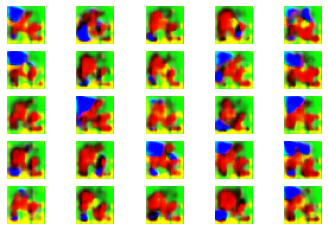

601 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.000656]
602 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.000333]
603 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.000521]
604 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.000634]
605 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.000601]
606 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.000649]
607 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.000435]
608 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.000733]
609 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.000537]
610 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.000382]
611 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.000720]
612 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.000809]
613 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.000432]
614 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.000502]
615 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.000818]
616 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.000657]
617 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.000370]
618 [D loss: 0.000033, acc.: 10

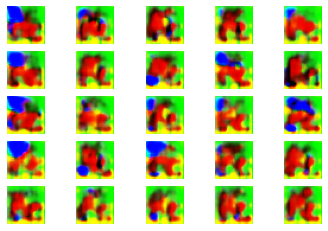

801 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.000213]
802 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.000509]
803 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.000427]
804 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.000710]
805 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.000364]
806 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.000399]
807 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.000435]
808 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.000505]
809 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.000575]
810 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.000331]
811 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.000408]
812 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.000624]
813 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.000750]
814 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.000597]
815 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.001027]
816 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.000430]
817 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.000581]
818 [D loss: 0.000026, acc.: 10

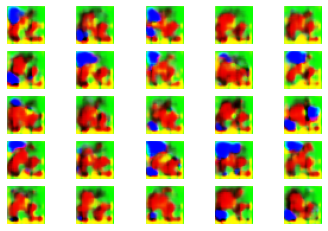

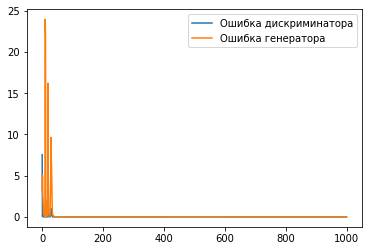

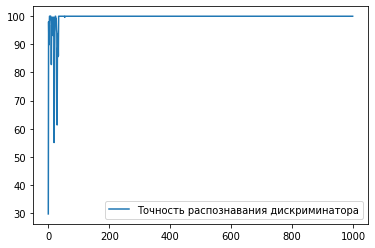

In [24]:
train_cifar(gen_2, d_2, 1000) # Вызываем функцию train_cifar

вывод такой: как-то это всё работает, но видимо с какими-то дополнениями, о которых нам не говорят.